# EDA for Electricity Demand Forecasting
## Exploration of the dataset

This is the EDA notebook for the electricity demand forecasting project. 
We are going through the data step by step to understand what we're working with.

### What we will be doing:
- Step 1: First, just checking the data looks okay
  - Step 1.1: Data coverage and gap analysis (after gap-filling)
- Step 2: Understanding the target variable (electricity load)
- Step 3: Visualizing the time series
- Step 4: Looking for seasonality patterns
- Step 5: Checking if data is stationary (for SARIMA)
- Step 6: Autocorrelation stuff
- Step 7: Calendar effects (weekends, holidays, etc.)
- Step 8: Weather variables 
- Step 9: Lag relationships
- Step 10: Peak loads
- Step 11: Error sensitivity
- Step 12: Multicollinearity check
- Step 13: Summary and decisions for modeling



---


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy import stats as scipy_stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import json
import os
from pathlib import Path


warnings.filterwarnings('ignore')

# Setting up plots 
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Make pandas show more columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("Libraries imported successfully!")
print("="*80)


Libraries imported successfully!


## Choosing the time resolution

I have data at different time resolutions. For now I'm using 60min (hourly) because:
- It's the most common for this type of analysis
- Less data to process = faster
- Still captures daily patterns well

Options:
- `15min`: 15-minute data (most detailed, but huge dataset)
- `30min`: 30-minute data (middle ground)
- `60min`: Hourly data (To be used further)

We will compare all three later to see if there's a big difference.


In [2]:
# Configuration: Select resolution for primary analysis
RESOLUTION = '60min'  # Options: '15min', '30min', '60min'
# Define paths based on resolution
DATA_PATH = f'processed_data_{RESOLUTION}/processed_data_{RESOLUTION}.csv'
REPORT_PATH = f'processed_data_{RESOLUTION}/preprocessing_report_{RESOLUTION}.json'

# Expected frequency mapping
FREQ_MAP = {
    '15min': '15T',
    '30min': '30T',
    '60min': 'H'
}

EXPECTED_FREQ = FREQ_MAP[RESOLUTION]

print(f"Selected Resolution: {RESOLUTION}")
print(f"Data Path: {DATA_PATH}")
print(f"Expected Frequency: {EXPECTED_FREQ}")
print("="*80)


Selected Resolution: 60min
Data Path: processed_data_60min/processed_data_60min.csv
Expected Frequency: H


---
# Step 1: Basic Data Checks


Checking:
1. How many rows/columns we have
2. What time period the data covers
3. If there are any missing timestamps
4. If there are missing values
5. Comparing all three resolutions



In [3]:
print("Loading data...")

try:
    df = pd.read_csv(DATA_PATH, parse_dates=['utc_timestamp'], index_col='utc_timestamp')
except (ValueError, KeyError):
   
    df = pd.read_csv(DATA_PATH, parse_dates=[0], index_col=0)
    if df.index.name is None or df.index.name == 'Unnamed: 0':
        df.index.name = 'utc_timestamp'
print(f"Data loaded successfully! Shape: {df.shape}")
print(f"Index name: {df.index.name}")
print(f"Index type: {type(df.index)}")
print(f"First timestamp: {df.index[0]}")

# Basic data checks
print("\n" + "="*80)
print("STEP 1: Data Checks")
print("="*80)

# 1. Dataset shape
print(f"\n1. Dataset Shape:")
print(f"   - Rows: {df.shape[0]:,}")
print(f"   - Columns: {df.shape[1]:,}")

# 2. Time range
print(f"\n2. Time Range:")
print(f"   - Start: {df.index.min()}")
print(f"   - End: {df.index.max()}")
print(f"   - Duration: {(df.index.max() - df.index.min()).days} days")
print(f"   - Duration: {(df.index.max() - df.index.min()).days / 365.25:.2f} years")

# 3. Expected frequency
print(f"\n3. Expected Frequency: {EXPECTED_FREQ}")

# 4. Check for missing timestamps
expected_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq=EXPECTED_FREQ)
missing_timestamps = expected_range.difference(df.index)
print(f"\n4. Missing Timestamps:")
print(f"   - Expected timestamps: {len(expected_range):,}")
print(f"   - Actual timestamps: {len(df.index):,}")
print(f"   - Missing timestamps: {len(missing_timestamps):,}")
if len(missing_timestamps) > 0:
    print(f"   - Missing percentage: {len(missing_timestamps)/len(expected_range)*100:.2f}%")
    if len(missing_timestamps) <= 20:
        print(f"   - Missing timestamps: {missing_timestamps.tolist()}")
else:
    print(f"   - No missing timestamps detected!")

# 5. Missing values per column
print(f"\n5. Missing Values per Column:")
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
if len(missing_summary) > 0:
    print(f"   - Columns with missing values: {len(missing_summary)}")
    print(f"   - Top 10 columns with most missing values:")
    for col, count in missing_summary.head(10).items():
        pct = (count / len(df)) * 100
        print(f"     * {col}: {count:,} ({pct:.2f}%)")
else:
    print(f"   - No missing values detected!")

print("\n" + "="*80)


Loading data...
Data loaded successfully! Shape: (32688, 83)
Index name: utc_timestamp
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
First timestamp: 2015-01-08 00:00:00+00:00

STEP 1: Data Checks

1. Dataset Shape:
   - Rows: 32,688
   - Columns: 83

2. Time Range:
   - Start: 2015-01-08 00:00:00+00:00
   - End: 2018-09-30 23:00:00+00:00
   - Duration: 1361 days
   - Duration: 3.73 years

3. Expected Frequency: H

4. Missing Timestamps:
   - Expected timestamps: 32,688
   - Actual timestamps: 32,688
   - Missing timestamps: 0
   - No missing timestamps detected!

5. Missing Values per Column:
   - No missing values detected!



In [4]:
# Visualize missing values
if df.isnull().sum().sum() > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Missing values heatmap 
    sample_size = min(1000, len(df))
    sample_df = df.iloc[::max(1, len(df)//sample_size)]
    
    missing_data = sample_df.isnull()
    sns.heatmap(missing_data.T, ax=axes[0], cbar=True, yticklabels=False, 
                cmap='viridis', xticklabels=False)
    axes[0].set_title('Missing Values Heatmap (Sampled)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Time Index (Sampled)', fontsize=12)
    axes[0].set_ylabel('Features', fontsize=12)
    
    # Missing values count by column
    missing_counts = df.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
    if len(missing_counts) > 0:
        axes[1].barh(range(len(missing_counts)), missing_counts.values)
        axes[1].set_yticks(range(len(missing_counts)))
        axes[1].set_yticklabels(missing_counts.index, fontsize=8)
        axes[1].set_xlabel('Number of Missing Values', fontsize=12)
        axes[1].set_title('Missing Values Count by Column', fontsize=14, fontweight='bold')
        axes[1].grid(axis='x', alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'No Missing Values!', 
                    ha='center', va='center', fontsize=16, fontweight='bold')
        axes[1].set_xticks([])
        axes[1].set_yticks([])
    
    plt.tight_layout()
    plt.savefig(f'eda_outputs/step3_missing_values_{RESOLUTION}.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No missing values to visualize!")


No missing values to visualize!


## Step 1.1: Data Coverage and Gap Analysis

Analyzing the processed data to check:
1. Data coverage and gaps after gap-filling
2. Missing values by feature
3. Overall data completeness



## Step 1.2: Data Coverage and Gap Analysis (After Gap-Filling)

This step analyzes the data after gap-filling to verify:
1. Data coverage and gaps after filling missing timestamps
2. Missing values by feature after gap-filling
3. Summary of what was filled and how





STEP 1.1: DATA COVERAGE AND GAP ANALYSIS

Analyzing processed data (after gap-filling)...
Processed data shape: (32688, 83)
Processed data time range: 2015-01-08 00:00:00+00:00 to 2018-09-30 23:00:00+00:00

--------------------------------------------------------------------------------
1. DATA COVERAGE AND GAPS AFTER FILLING MISSING TIMESTAMPS
--------------------------------------------------------------------------------
Time range: 2015-01-08 00:00:00+00:00 to 2018-09-30 23:00:00+00:00
Expected timestamps: 32,688
Actual timestamps (after filling): 32,688
Missing timestamps (after filling): 0
Coverage (after filling): 100.00%

  Perfect coverage! All expected timestamps are present after gap-filling.

--------------------------------------------------------------------------------
2. MISSING VALUES BY FEATURE (AFTER GAP-FILLING)
--------------------------------------------------------------------------------
  No missing values! All features are complete after gap-filling.

-------

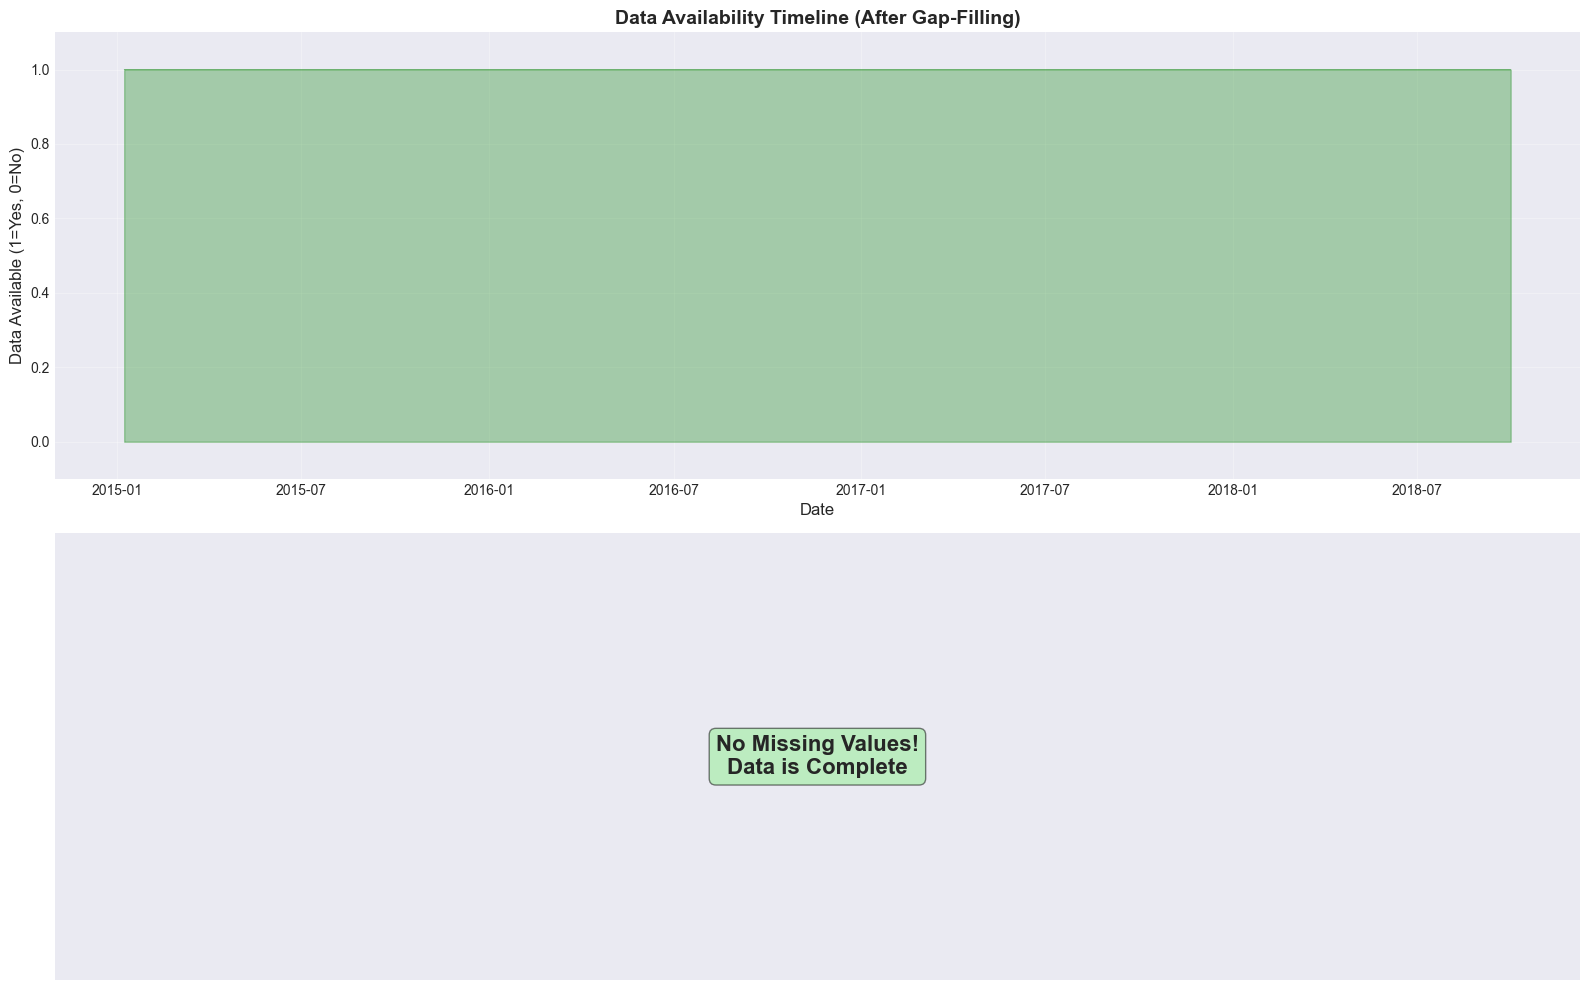


STEP 1.1 COMPLETE


In [5]:
print("\n" + "="*80)
print("STEP 1.1: DATA COVERAGE AND GAP ANALYSIS")
print("="*80)

print("\nAnalyzing processed data (after gap-filling)...")
print(f"Processed data shape: {df.shape}")
print(f"Processed data time range: {df.index.min()} to {df.index.max()}")

print("\n" + "-"*80)
print("1. DATA COVERAGE AND GAPS AFTER FILLING MISSING TIMESTAMPS")
print("-"*80)

start_time = df.index.min()
end_time = df.index.max()
expected_range = pd.date_range(start=start_time, end=end_time, freq=EXPECTED_FREQ)
actual_timestamps = df.index

missing_timestamps_after = expected_range.difference(actual_timestamps)
coverage_after = (len(actual_timestamps) / len(expected_range)) * 100

print(f"Time range: {start_time} to {end_time}")
print(f"Expected timestamps: {len(expected_range):,}")
print(f"Actual timestamps (after filling): {len(actual_timestamps):,}")
print(f"Missing timestamps (after filling): {len(missing_timestamps_after):,}")
print(f"Coverage (after filling): {coverage_after:.2f}%")

if len(missing_timestamps_after) > 0:
    print(f"\nWARNING: Still have {len(missing_timestamps_after):,} missing timestamps after gap-filling!")
    print(f"   Gap percentage: {len(missing_timestamps_after)/len(expected_range)*100:.2f}%")
else:
    print("\n  Perfect coverage! All expected timestamps are present after gap-filling.")

print("\n" + "-"*80)
print("2. MISSING VALUES BY FEATURE (AFTER GAP-FILLING)")
print("-"*80)

missing_after = df.isnull().sum()
missing_after = missing_after[missing_after > 0].sort_values(ascending=False)

if len(missing_after) > 0:
    print(f"Features with missing values: {len(missing_after)}")
    print(f"\nTop 20 features with most missing values:")
    for col, count in missing_after.head(20).items():
        pct = (count / len(df)) * 100
        print(f"  * {col}: {count:,} ({pct:.2f}%)")
    
    fig, ax = plt.subplots(figsize=(12, max(8, len(missing_after.head(20)) * 0.3)))
    top_missing = missing_after.head(20)
    ax.barh(range(len(top_missing)), top_missing.values, color='orange', alpha=0.7)
    ax.set_yticks(range(len(top_missing)))
    ax.set_yticklabels(top_missing.index, fontsize=9)
    ax.set_xlabel('Number of Missing Values', fontsize=12)
    ax.set_title('Missing Values by Feature (After Gap-Filling)', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'eda_outputs/step1.2_missing_values_by_feature_after_{RESOLUTION}.png', 
               dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("  No missing values! All features are complete after gap-filling.")

print("\n" + "-"*80)
print("3. SUMMARY")
print("-"*80)

print("\nProcessed data status:")
print(f"  - Total timestamps: {len(df):,}")
print(f"  - Missing timestamps: {len(missing_timestamps_after):,}")
print(f"  - Total missing values: {df.isnull().sum().sum():,}")
if df.isnull().sum().sum() == 0:
    print("  - Data is complete!")

print("\n" + "-"*80)
print("4. VISUALIZATION: Data Coverage Timeline")
print("-"*80)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

sample_size = min(5000, len(df))
sample_idx = np.linspace(0, len(df)-1, sample_size, dtype=int)
sample_dates = df.index[sample_idx]
sample_data = df.iloc[sample_idx, 0]

axes[0].plot(sample_dates, sample_data.notna().astype(int), alpha=0.6, linewidth=0.5, color='green')
axes[0].fill_between(sample_dates, 0, sample_data.notna().astype(int), alpha=0.3, color='green')
axes[0].set_title('Data Availability Timeline (After Gap-Filling)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Data Available (1=Yes, 0=No)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.1, 1.1)

if df.isnull().sum().sum() > 0:
    heatmap_sample = df.iloc[::max(1, len(df)//1000)]
    missing_heatmap = heatmap_sample.isnull()
    
    axes[1].imshow(missing_heatmap.T.values, aspect='auto', cmap='Reds', interpolation='nearest')
    axes[1].set_title('Missing Values Heatmap (After Gap-Filling)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time Index (Sampled)', fontsize=12)
    axes[1].set_ylabel('Features', fontsize=12)
else:
    axes[1].text(0.5, 0.5, 'No Missing Values!\nData is Complete', 
                ha='center', va='center', fontsize=16, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    axes[1].set_xticks([])
    axes[1].set_yticks([])

plt.tight_layout()
plt.savefig(f'../saved_model_outputs/eda_outputs/step1.1_coverage_timeline_after_{RESOLUTION}.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("STEP 1.1 COMPLETE")
print("="*80)


---
# Step 2: Understanding the Target Variable

The target variable is electricity load (demand) in MW. I want to understand:
- What's the typical load? (mean, median)
- How much does it vary? (std, variance)
- Is it normally distributed?
- Are there outliers?
- What are the min/max values?

This will help me understand what I'm trying to predict and set reasonable expectations for model performance.


In [6]:
#  3: Looking at the target variable
print("="*80)
print("STEP 2: TARGET VARIABLE UNDERSTANDING")
print("="*80)

target = df['target_load'].copy()

# Basic stats first
print("\n1. Statistical Summary:")
stats_summary = {
    'Count': len(target),
    'Mean': target.mean(),
    'Median': target.median(),
    'Std Dev': target.std(),
    'Variance': target.var(),
    'Min': target.min(),
    'Max': target.max(),
    'Range': target.max() - target.min(),
    '25th Percentile': target.quantile(0.25),
    '75th Percentile': target.quantile(0.75),
    'IQR': target.quantile(0.75) - target.quantile(0.25),
    'Skewness': scipy_stats.skew(target),
    'Kurtosis': scipy_stats.kurtosis(target)
}

for key, value in stats_summary.items():
    if isinstance(value, float):
        print(f"   {key:20s}: {value:,.2f}")
    else:
        print(f"   {key:20s}: {value:,}")

# Identify outliers using IQR method
Q1 = target.quantile(0.25)
Q3 = target.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = target[(target < lower_bound) | (target > upper_bound)]

print(f"\n2. Outlier Analysis (IQR Method):")
print(f"   - Lower bound: {lower_bound:,.2f} MW")
print(f"   - Upper bound: {upper_bound:,.2f} MW")
print(f"   - Number of outliers: {len(outliers_iqr):,} ({len(outliers_iqr)/len(target)*100:.2f}%)")

# Percentiles
print(f"\n3. Percentiles:")
for p in [10, 25, 50, 75, 90, 95, 99]:
    print(f"   - {p}th percentile: {target.quantile(p/100):,.2f} MW")

print("\n" + "="*80)


STEP 2: TARGET VARIABLE UNDERSTANDING

1. Statistical Summary:
   Count               : 32,688
   Mean                : 55,697.94
   Median              : 55,368.00
   Std Dev             : 10,025.70
   Variance            : 100,514,655.33
   Min                 : 31,307.00
   Max                 : 77,549.00
   Range               : 46,242.00
   25th Percentile     : 47,179.75
   75th Percentile     : 64,719.25
   IQR                 : 17,539.50
   Skewness            : -0.04
   Kurtosis            : -1.15

2. Outlier Analysis (IQR Method):
   - Lower bound: 20,870.50 MW
   - Upper bound: 91,028.50 MW
   - Number of outliers: 0 (0.00%)

3. Percentiles:
   - 10th percentile: 42,685.10 MW
   - 25th percentile: 47,179.75 MW
   - 50th percentile: 55,368.00 MW
   - 75th percentile: 64,719.25 MW
   - 90th percentile: 68,855.00 MW
   - 95th percentile: 70,683.00 MW
   - 99th percentile: 73,434.00 MW



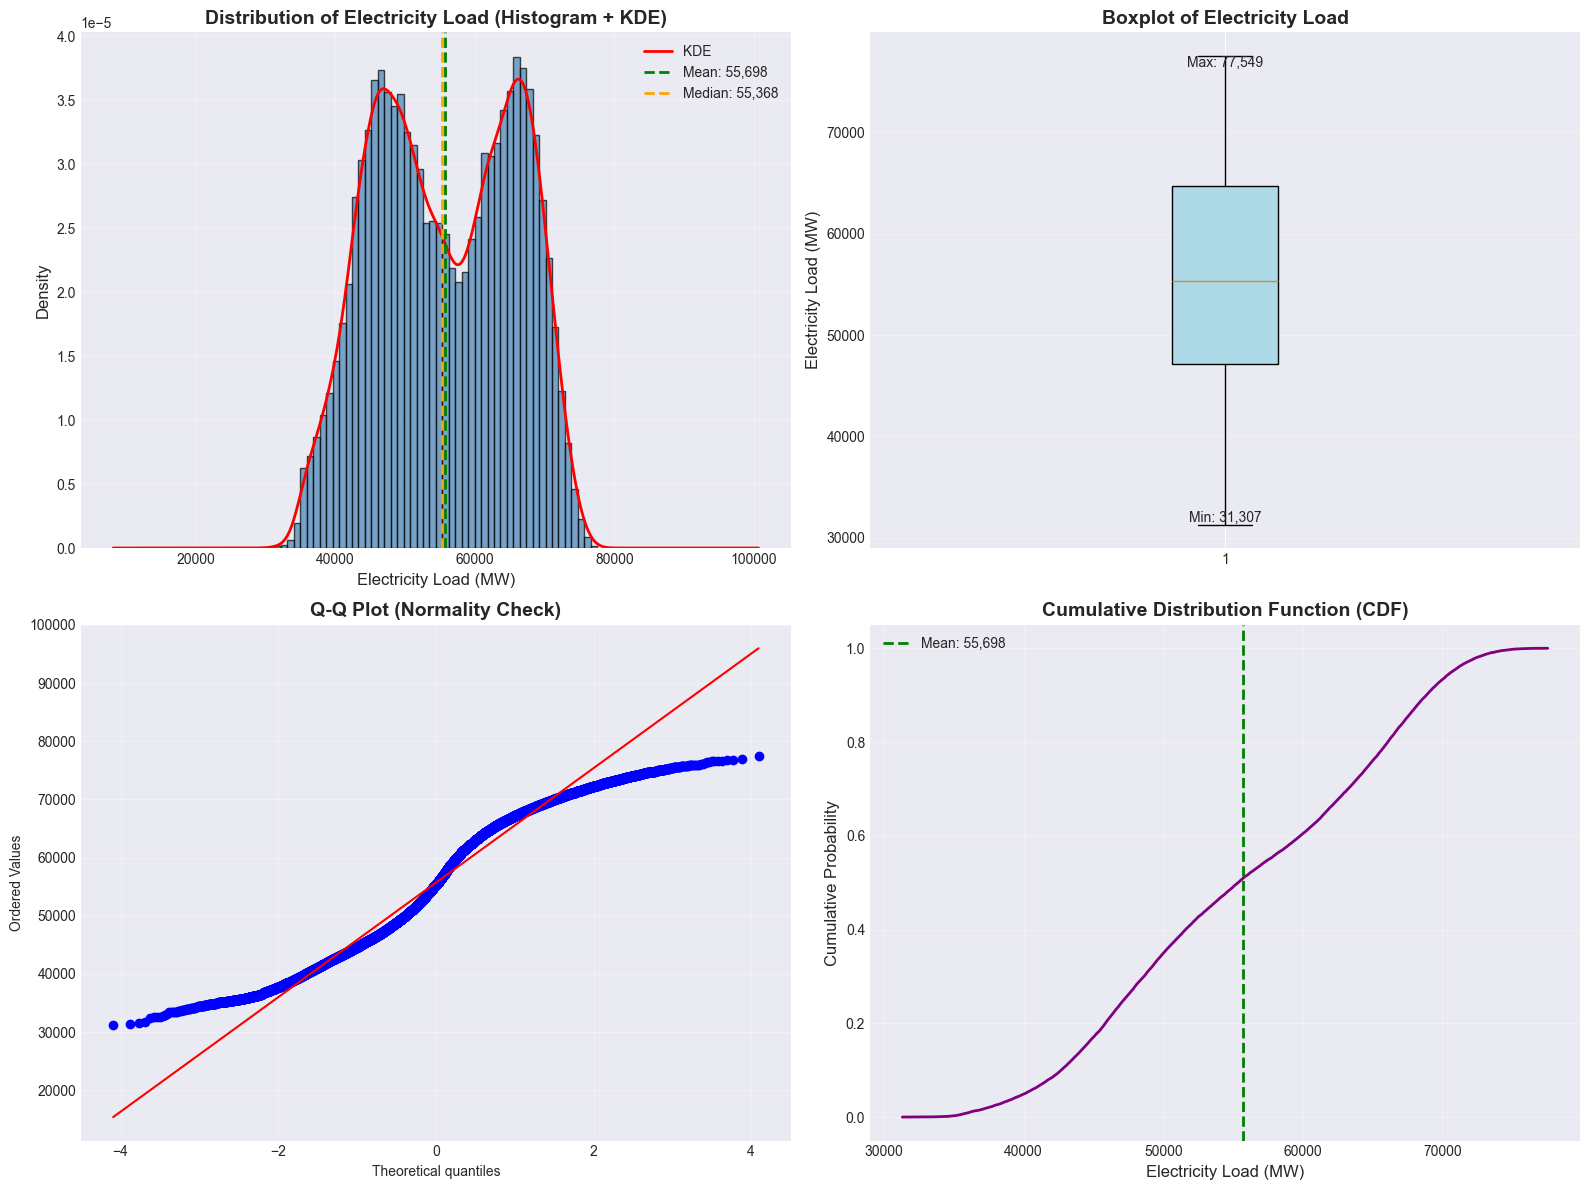

Step 1 visualizations saved!


In [7]:
# Visualizations for Step 1
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram with KDE
axes[0, 0].hist(target, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
target.plot.density(ax=axes[0, 0], color='red', linewidth=2, label='KDE')
axes[0, 0].axvline(target.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {target.mean():,.0f}')
axes[0, 0].axvline(target.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {target.median():,.0f}')
axes[0, 0].set_xlabel('Electricity Load (MW)', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].set_title('Distribution of Electricity Load (Histogram + KDE)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Boxplot
bp = axes[0, 1].boxplot(target.values, vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
axes[0, 1].set_ylabel('Electricity Load (MW)', fontsize=12)
axes[0, 1].set_title('Boxplot of Electricity Load', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='y')
axes[0, 1].text(1, target.min(), f'Min: {target.min():,.0f}', ha='center', va='bottom', fontsize=10)
axes[0, 1].text(1, target.max(), f'Max: {target.max():,.0f}', ha='center', va='top', fontsize=10)

# 3. Q-Q Plot (normality check)
scipy_stats.probplot(target, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 4. Cumulative Distribution
sorted_target = np.sort(target)
cumulative = np.arange(1, len(sorted_target) + 1) / len(sorted_target)
axes[1, 1].plot(sorted_target, cumulative, linewidth=2, color='purple')
axes[1, 1].axvline(target.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {target.mean():,.0f}')
axes[1, 1].set_xlabel('Electricity Load (MW)', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
axes[1, 1].set_title('Cumulative Distribution Function (CDF)', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'../saved_model_outputs/eda_outputs/step2_target_distribution_{RESOLUTION}.png', dpi=300, bbox_inches='tight')
plt.show()

print("Step 1 visualizations saved!")


---
# Step 3: Visualizing the Time Series

Lets plot the electricity load over time to see:
- The overall trend
- Daily patterns
- Seasonal patterns
- Any weird anomalies or changes

we will look at different time scales (full period, zoomed in to weeks/months) to see patterns at different levels.


STEP 3: TIME SERIES VISUALIZATION


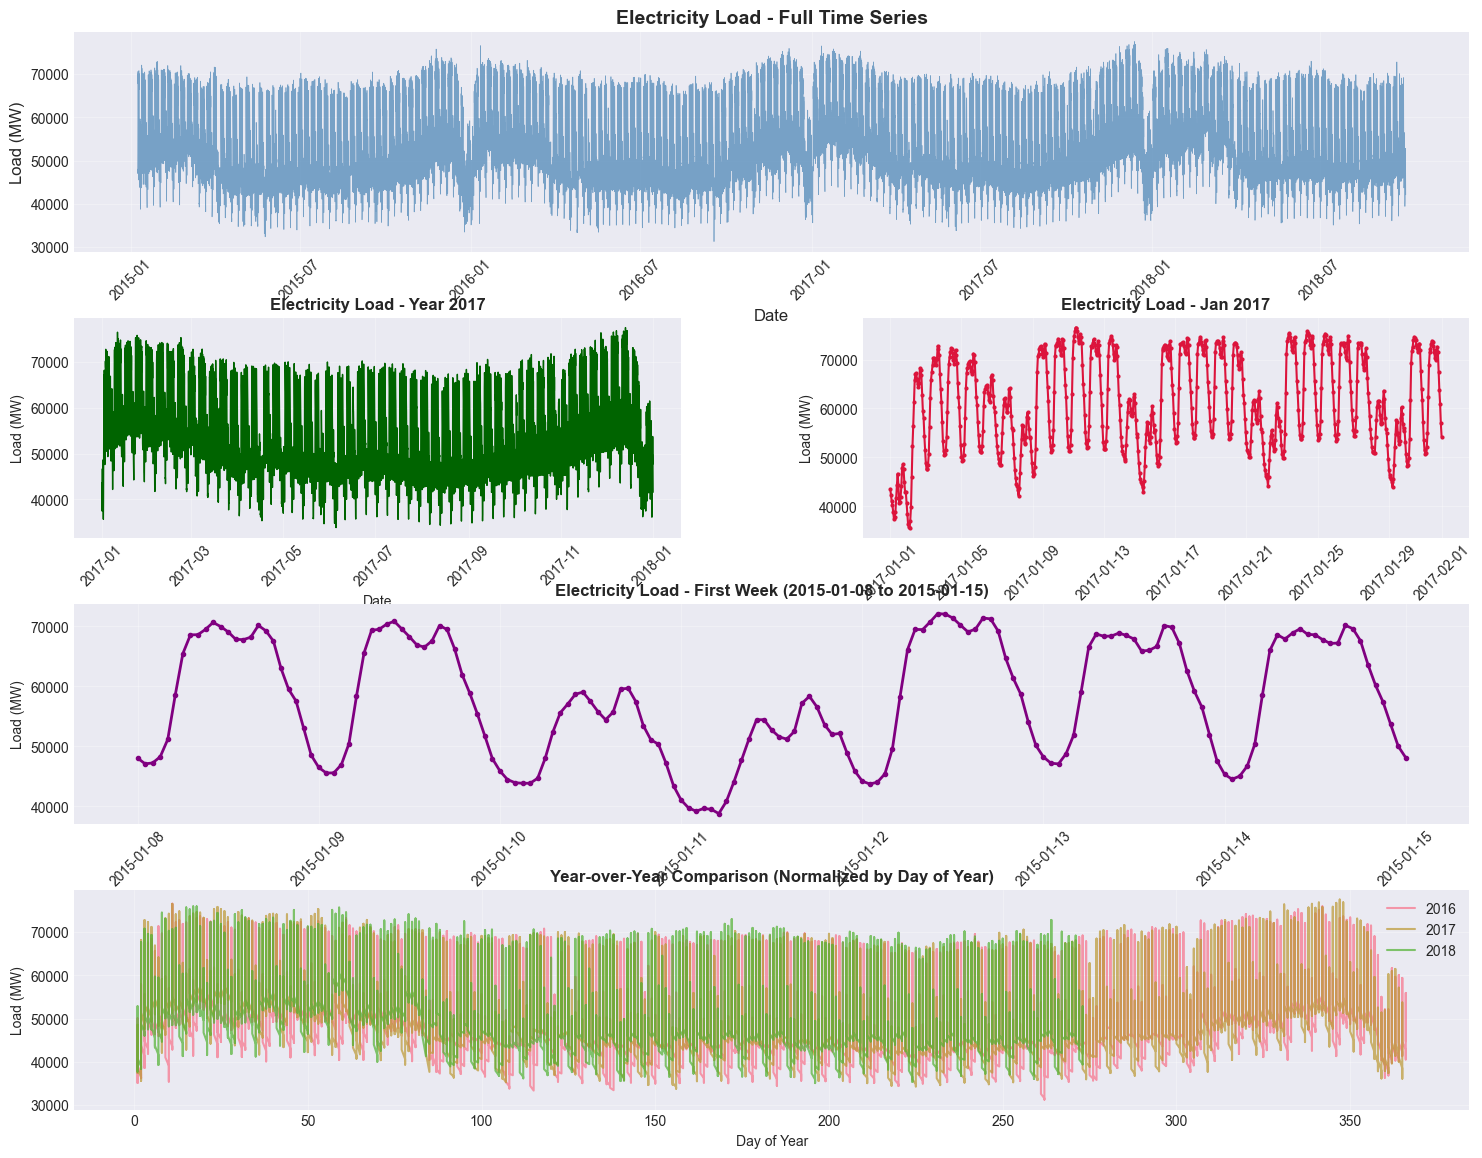

Step 3 visualizations saved!



In [8]:
# Step 3: Plotting the time series
print("="*80)
print("STEP 3: TIME SERIES VISUALIZATION")
print("="*80)

# Making some plots to see what the data looks like over time
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

# 1. Full time series
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df.index, target, linewidth=0.5, alpha=0.7, color='steelblue')
ax1.set_title('Electricity Load - Full Time Series', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Load (MW)', fontsize=12)
ax1.grid(alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. One year view 
if len(df) > 365 * 24:
    available_years = sorted(target.index.year.unique())
    if len(available_years) > 0:
        # Use middle year if multiple years, otherwise use the only year
        selected_year = available_years[len(available_years) // 2]
        year_data = target[target.index.year == selected_year]
        if len(year_data) > 0:
            ax2 = fig.add_subplot(gs[1, 0])
            ax2.plot(year_data.index, year_data.values, linewidth=1, color='darkgreen')
            ax2.set_title(f'Electricity Load - Year {selected_year}', fontsize=12, fontweight='bold')
            ax2.set_xlabel('Date', fontsize=10)
            ax2.set_ylabel('Load (MW)', fontsize=10)
            ax2.grid(alpha=0.3)
            ax2.tick_params(axis='x', rotation=45)

# 3. One month view 
if len(df) > 30 * 24:
    available_years = sorted(target.index.year.unique())
    if len(available_years) > 0:
        selected_year = available_years[len(available_years) // 2]
        # Try January first, if not available use first available month
        month_data = target[(target.index.year == selected_year) & (target.index.month == 1)]
        if len(month_data) == 0:
            # If January not available, use first available month
            available_months = sorted(target[target.index.year == selected_year].index.month.unique())
            if len(available_months) > 0:
                month_data = target[(target.index.year == selected_year) & (target.index.month == available_months[0])]
                selected_month = available_months[0]
            else:
                selected_month = 1
        else:
            selected_month = 1
        
        if len(month_data) > 0:
            month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            ax3 = fig.add_subplot(gs[1, 1])
            ax3.plot(month_data.index, month_data.values, linewidth=1.5, color='crimson', marker='o', markersize=2)
            ax3.set_title(f'Electricity Load - {month_names[selected_month-1]} {selected_year}', fontsize=12, fontweight='bold')
            ax3.set_xlabel('Date', fontsize=10)
            ax3.set_ylabel('Load (MW)', fontsize=10)
            ax3.grid(alpha=0.3)
            ax3.tick_params(axis='x', rotation=45)

# 4. One week view
if len(df) > 7 * 24:
    week_start = target.index[0] + timedelta(days=7)
    week_data = target[target.index <= week_start]
    if len(week_data) > 0:
        ax4 = fig.add_subplot(gs[2, :])
        ax4.plot(week_data.index, week_data.values, linewidth=2, color='purple', marker='o', markersize=3)
        ax4.set_title(f'Electricity Load - First Week ({week_data.index[0].strftime("%Y-%m-%d")} to {week_data.index[-1].strftime("%Y-%m-%d")})', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Date', fontsize=10)
        ax4.set_ylabel('Load (MW)', fontsize=10)
        ax4.grid(alpha=0.3)
        ax4.tick_params(axis='x', rotation=45)

# 5. Year-over-year comparison
years = sorted(target.index.year.unique())
if len(years) >= 2:
    ax5 = fig.add_subplot(gs[3, :])
    for year in years[-3:]:  # Last 3 years
        year_data = target[target.index.year == year]
        if len(year_data) > 0:
            # Normalize to day of year for comparison
            year_data_normalized = year_data.copy()
            year_data_normalized.index = year_data_normalized.index.dayofyear
            ax5.plot(year_data_normalized.index, year_data_normalized.values, 
                    linewidth=1.5, alpha=0.7, label=f'{year}')
    ax5.set_title('Year-over-Year Comparison (Normalized by Day of Year)', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Day of Year', fontsize=10)
    ax5.set_ylabel('Load (MW)', fontsize=10)
    ax5.legend()
    ax5.grid(alpha=0.3)

plt.savefig(f'../saved_model_outputs/eda_outputs/step3_timeseries_{RESOLUTION}.png', dpi=300, bbox_inches='tight')
plt.show()

print("Step 3 visualizations saved!")
print("\n" + "="*80)


In [9]:
# STEP 4: Seasonality Analysis
print("="*80)
print("STEP 4: SEASONALITY ANALYSIS")
print("="*80)

# Create a copy with datetime features
df_seasonal = df.copy()
df_seasonal['hour'] = df_seasonal.index.hour
df_seasonal['day_of_week'] = df_seasonal.index.dayofweek
df_seasonal['month'] = df_seasonal.index.month
df_seasonal['day_of_year'] = df_seasonal.index.dayofyear

# 1. Average load by hour of day
print("\n1. Daily Seasonality (24-hour pattern):")
hourly_avg = df_seasonal.groupby('hour')['target_load'].mean()
print(f"   - Peak hour: {hourly_avg.idxmax()} ({hourly_avg.max():,.2f} MW)")
print(f"   - Minimum hour: {hourly_avg.idxmin()} ({hourly_avg.min():,.2f} MW)")
print(f"   - Range: {hourly_avg.max() - hourly_avg.min():,.2f} MW")

# 2. Average load by day of week
print("\n2. Weekly Seasonality (7-day pattern):")
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = df_seasonal.groupby('day_of_week')['target_load'].mean()
print(f"   - Peak day: {day_names[daily_avg.idxmax()]} ({daily_avg.max():,.2f} MW)")
print(f"   - Minimum day: {day_names[daily_avg.idxmin()]} ({daily_avg.min():,.2f} MW)")

# 3. Average load by month
print("\n3. Monthly Seasonality:")
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_avg = df_seasonal.groupby('month')['target_load'].mean()
print(f"   - Peak month: {month_names[monthly_avg.idxmax()-1]} ({monthly_avg.max():,.2f} MW)")
print(f"   - Minimum month: {month_names[monthly_avg.idxmin()-1]} ({monthly_avg.min():,.2f} MW)")

print("\n" + "="*80)


STEP 4: SEASONALITY ANALYSIS

1. Daily Seasonality (24-hour pattern):
   - Peak hour: 10 (64,056.05 MW)
   - Minimum hour: 1 (43,554.14 MW)
   - Range: 20,501.91 MW

2. Weekly Seasonality (7-day pattern):
   - Peak day: Wednesday (59,843.14 MW)
   - Minimum day: Sunday (45,844.44 MW)

3. Monthly Seasonality:
   - Peak month: Feb (59,877.32 MW)
   - Minimum month: May (52,645.55 MW)



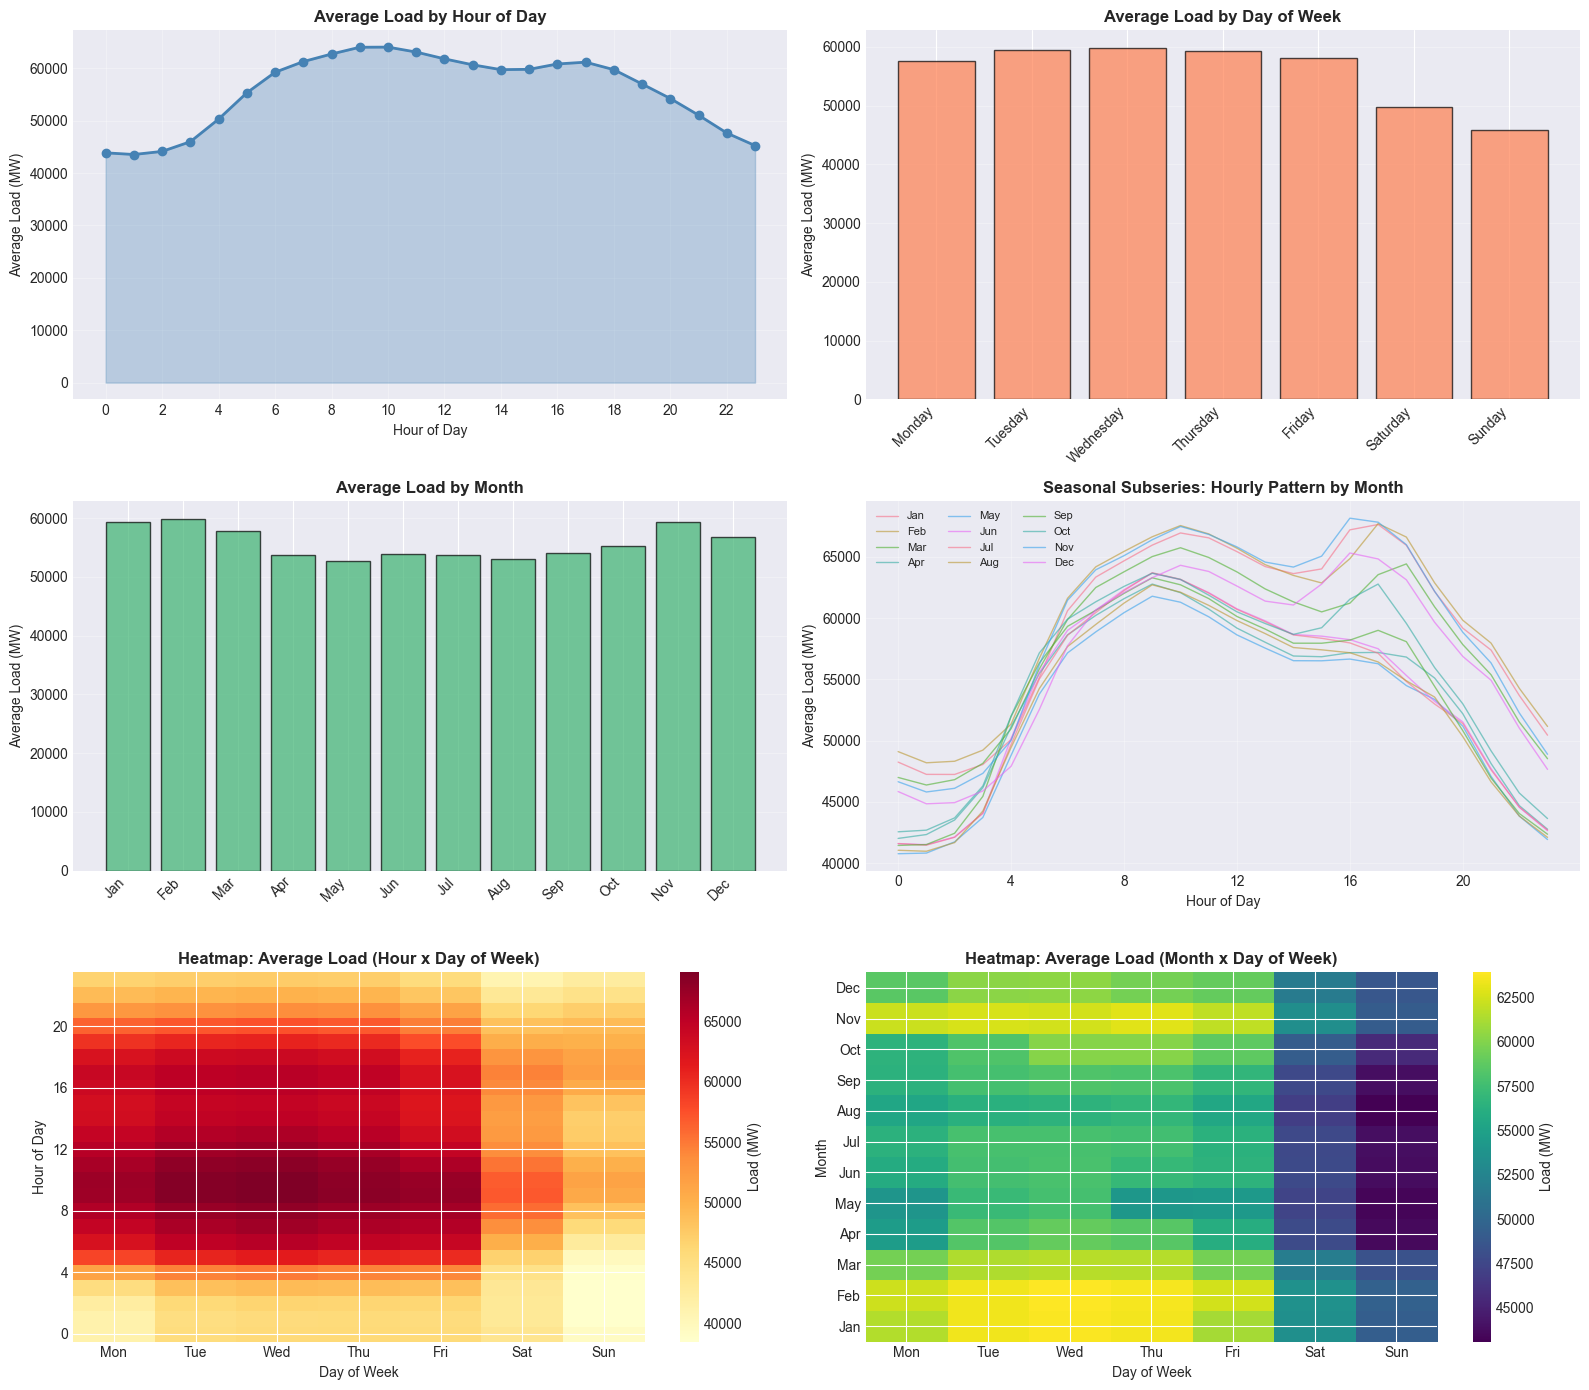

Step 4 visualizations saved!


In [10]:
# Visualizations for Step 4
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# 1. Average load by hour of day
axes[0, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=6, color='steelblue')
axes[0, 0].fill_between(hourly_avg.index, hourly_avg.values, alpha=0.3, color='steelblue')
axes[0, 0].set_title('Average Load by Hour of Day', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Hour of Day', fontsize=10)
axes[0, 0].set_ylabel('Average Load (MW)', fontsize=10)
axes[0, 0].set_xticks(range(0, 24, 2))
axes[0, 0].grid(alpha=0.3)

# 2. Average load by day of week
axes[0, 1].bar(range(7), daily_avg.values, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names, rotation=45, ha='right')
axes[0, 1].set_title('Average Load by Day of Week', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Average Load (MW)', fontsize=10)
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Average load by month
axes[1, 0].bar(range(1, 13), monthly_avg.values, color='mediumseagreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(month_names, rotation=45, ha='right')
axes[1, 0].set_title('Average Load by Month', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Average Load (MW)', fontsize=10)
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Seasonal subseries plot - by hour
hourly_by_month = df_seasonal.groupby(['month', 'hour'])['target_load'].mean().unstack(level=0)
axes[1, 1].plot(hourly_by_month.index, hourly_by_month.values, alpha=0.6, linewidth=1)
axes[1, 1].set_title('Seasonal Subseries: Hourly Pattern by Month', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Hour of Day', fontsize=10)
axes[1, 1].set_ylabel('Average Load (MW)', fontsize=10)
axes[1, 1].set_xticks(range(0, 24, 4))
axes[1, 1].grid(alpha=0.3)
axes[1, 1].legend(month_names, loc='upper left', fontsize=8, ncol=3)

# 5. Heatmap: Hour x Day of Week
hour_day_avg = df_seasonal.groupby(['hour', 'day_of_week'])['target_load'].mean().unstack()
im = axes[2, 0].imshow(hour_day_avg.values, aspect='auto', cmap='YlOrRd', origin='lower')
axes[2, 0].set_title('Heatmap: Average Load (Hour x Day of Week)', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Day of Week', fontsize=10)
axes[2, 0].set_ylabel('Hour of Day', fontsize=10)
axes[2, 0].set_xticks(range(7))
axes[2, 0].set_xticklabels([d[:3] for d in day_names])
axes[2, 0].set_yticks(range(0, 24, 4))
plt.colorbar(im, ax=axes[2, 0], label='Load (MW)')

# 6. Heatmap: Month x Day of Week
month_day_avg = df_seasonal.groupby(['month', 'day_of_week'])['target_load'].mean().unstack()
im2 = axes[2, 1].imshow(month_day_avg.values, aspect='auto', cmap='viridis', origin='lower')
axes[2, 1].set_title('Heatmap: Average Load (Month x Day of Week)', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Day of Week', fontsize=10)
axes[2, 1].set_ylabel('Month', fontsize=10)
axes[2, 1].set_xticks(range(7))
axes[2, 1].set_xticklabels([d[:3] for d in day_names])
axes[2, 1].set_yticks(range(12))
axes[2, 1].set_yticklabels(month_names)
plt.colorbar(im2, ax=axes[2, 1], label='Load (MW)')

plt.tight_layout()
plt.savefig(f'../saved_model_outputs/eda_outputs/step4_seasonality_{RESOLUTION}.png', dpi=300, bbox_inches='tight')
plt.show()

print("Step 4 visualizations saved!")



5. STL Decomposition (Trend, Seasonal, Residual):


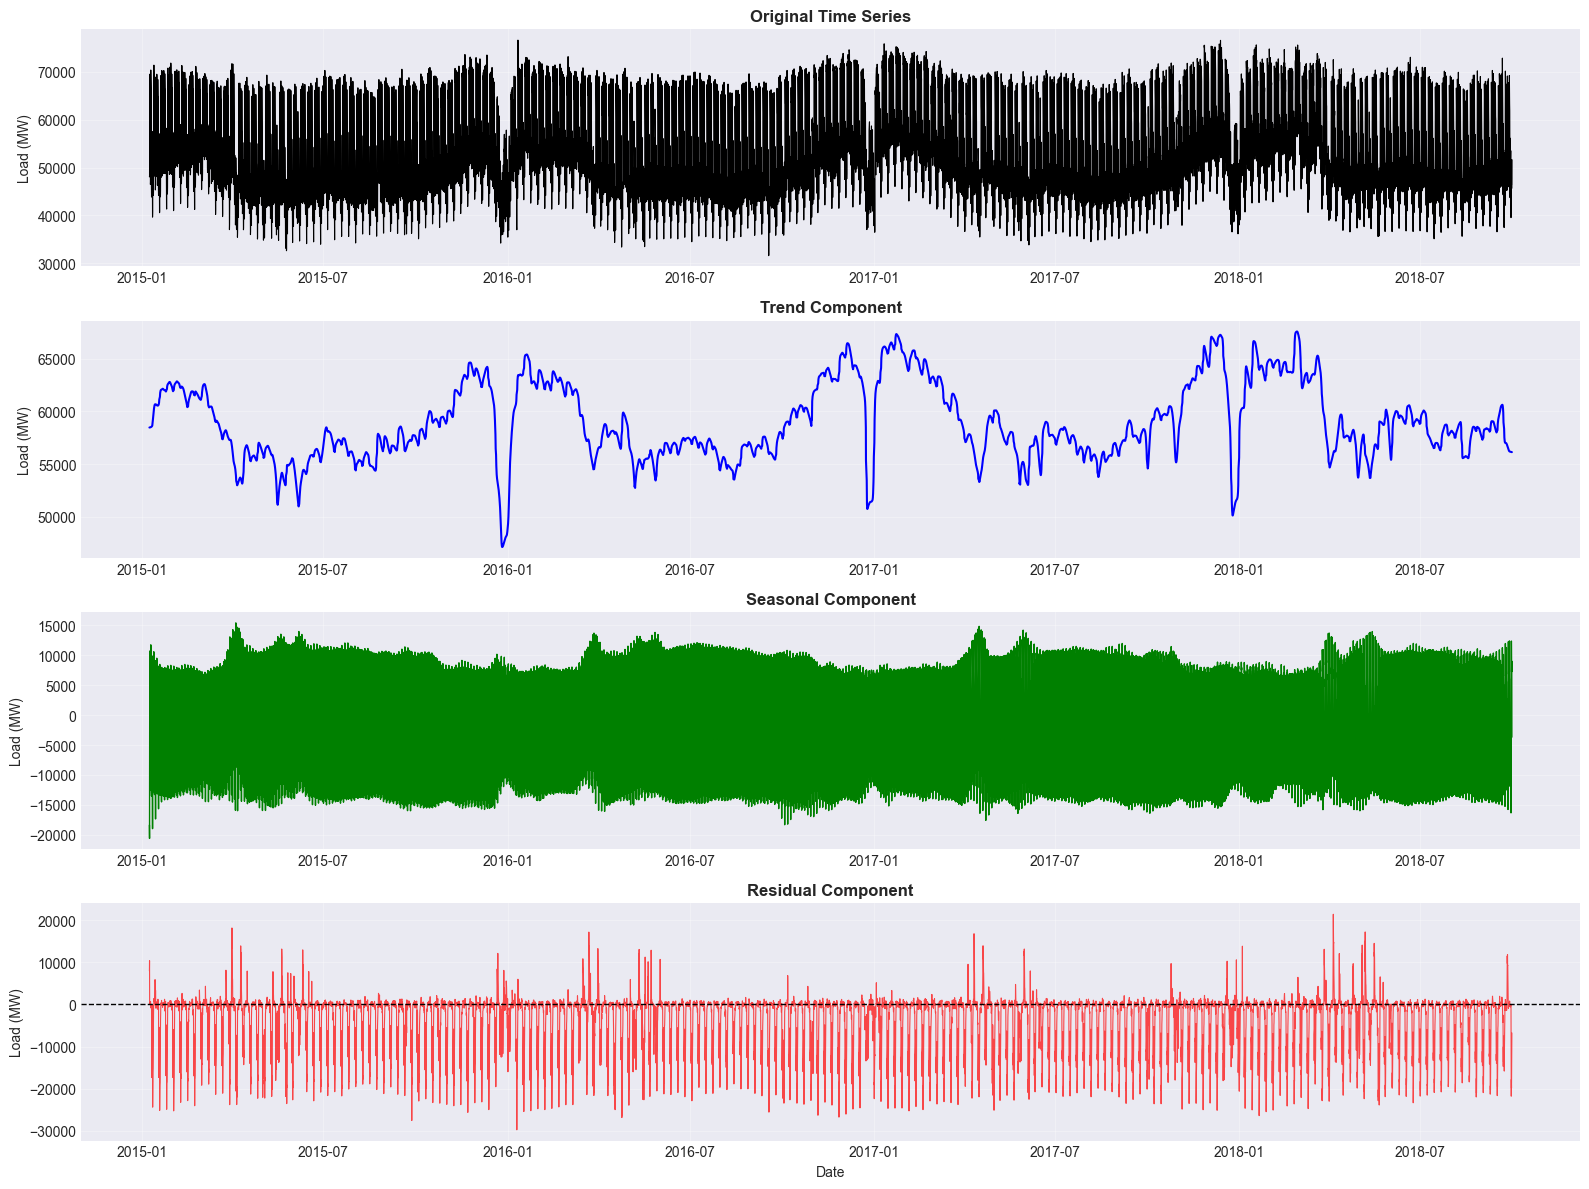

   - Trend range: 47,122.95 to 67,581.32 MW
   - Seasonal range: -20,598.02 to 15,394.99 MW
   - Residual std: 6,153.59 MW
   - Residual mean: -3,261.24 MW



In [11]:
# STL Decomposition
print("\n5. STL Decomposition (Trend, Seasonal, Residual):")
try:
    # For hourly data, use period=24 for daily seasonality
    if RESOLUTION == '60min':
        period = 24  # Daily seasonality
    elif RESOLUTION == '30min':
        period = 48  # Daily seasonality (48 half-hours)
    else:  # 15min
        period = 96  # Daily seasonality (96 quarter-hours)
    
    # Sample if too large for STL
    if len(target) > 10000:
        sample_target = target.iloc[::max(1, len(target)//10000)]
    else:
        sample_target = target
    
    stl = STL(sample_target, period=period, robust=True)
    result = stl.fit()
    
    # Plot STL decomposition
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    
    axes[0].plot(sample_target.index, sample_target.values, linewidth=0.8, color='black')
    axes[0].set_title('Original Time Series', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Load (MW)', fontsize=10)
    axes[0].grid(alpha=0.3)
    
    axes[1].plot(result.trend.index, result.trend.values, linewidth=1.5, color='blue')
    axes[1].set_title('Trend Component', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Load (MW)', fontsize=10)
    axes[1].grid(alpha=0.3)
    
    axes[2].plot(result.seasonal.index, result.seasonal.values, linewidth=1, color='green')
    axes[2].set_title('Seasonal Component', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Load (MW)', fontsize=10)
    axes[2].grid(alpha=0.3)
    
    axes[3].plot(result.resid.index, result.resid.values, linewidth=0.8, color='red', alpha=0.7)
    axes[3].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[3].set_title('Residual Component', fontsize=12, fontweight='bold')
    axes[3].set_xlabel('Date', fontsize=10)
    axes[3].set_ylabel('Load (MW)', fontsize=10)
    axes[3].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'../saved_model_outputs/eda_outputs/step5_stl_decomposition_{RESOLUTION}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print decomposition statistics
    print(f"   - Trend range: {result.trend.min():,.2f} to {result.trend.max():,.2f} MW")
    print(f"   - Seasonal range: {result.seasonal.min():,.2f} to {result.seasonal.max():,.2f} MW")
    print(f"   - Residual std: {result.resid.std():,.2f} MW")
    print(f"   - Residual mean: {result.resid.mean():,.2f} MW")
    
except Exception as e:
    print(f"   - [WARNING] STL decomposition failed: {e}")
    print("   - This may be due to data size or period selection")

print("\n" + "="*80)


---
# EDA STEP 6 — Stationarity Check 

## Purpose
Test for stationarity to determine differencing requirements for SARIMA models.

## What We Test:
1. Augmented Dickey-Fuller (ADF) test
2. KPSS test (optional but recommended)



STEP 6: STATIONARITY CHECK

1. Augmented Dickey-Fuller (ADF) Test:
   H0: Series has a unit root (non-stationary)
   H1: Series is stationary
   - ADF Statistic: -5.3896
   - p-value: 0.0000
   - Critical Values:
     * 1%: -3.4316
     * 5%: -2.8621
     * 10%: -2.5671
   - [RESULT] Reject H0: Series is STATIONARY (p=0.0000 <= 0.05)
   - [IMPLICATION] No differencing needed (d=0)

2. KPSS Test:
   H0: Series is trend-stationary
   H1: Series has a unit root (non-stationary)
   - KPSS Statistic: 0.2044
   - p-value: 0.0143
   - Critical Values:
     * 10%: 0.1190
     * 5%: 0.1460
     * 2.5%: 0.1760
     * 1%: 0.2160
   - [RESULT] Reject H0: Series has UNIT ROOT (p=0.0143 < 0.05)
   - [IMPLICATION] Differencing needed

3. Visual Inspection:


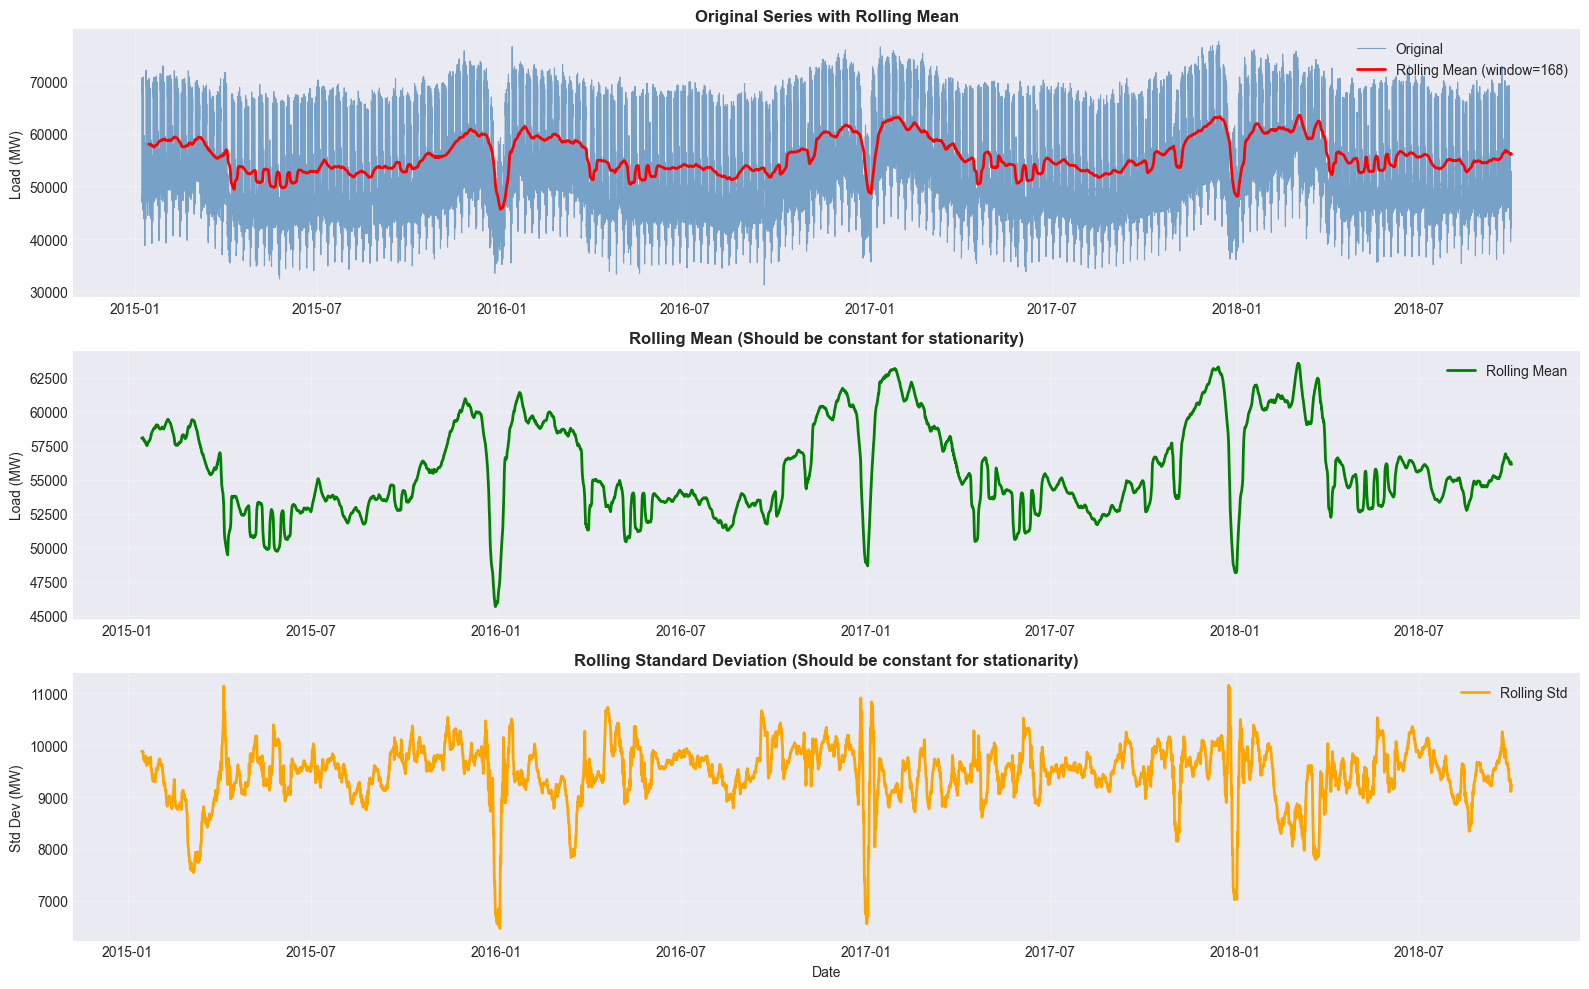

In [12]:
# STEP 5: Stationarity Check
print("="*80)
print("STEP 6: STATIONARITY CHECK")
print("="*80)

# Sample data if too large
if len(target) > 5000:
    sample_target = target.iloc[::max(1, len(target)//5000)]
else:
    sample_target = target

# 1. Augmented Dickey-Fuller (ADF) Test
print("\n1. Augmented Dickey-Fuller (ADF) Test:")
print("   H0: Series has a unit root (non-stationary)")
print("   H1: Series is stationary")
try:
    adf_result = adfuller(sample_target, autolag='AIC')
    adf_statistic = adf_result[0]
    adf_pvalue = adf_result[1]
    adf_critical = adf_result[4]
    
    print(f"   - ADF Statistic: {adf_statistic:.4f}")
    print(f"   - p-value: {adf_pvalue:.4f}")
    print(f"   - Critical Values:")
    for key, value in adf_critical.items():
        print(f"     * {key}: {value:.4f}")
    
    if adf_pvalue <= 0.05:
        print(f"   - [RESULT] Reject H0: Series is STATIONARY (p={adf_pvalue:.4f} <= 0.05)")
        print(f"   - [IMPLICATION] No differencing needed (d=0)")
    else:
        print(f"   - [RESULT] Fail to reject H0: Series is NON-STATIONARY (p={adf_pvalue:.4f} > 0.05)")
        print(f"   - [IMPLICATION] Differencing needed (d>=1)")
except Exception as e:
    print(f"   - [ERROR] ADF test failed: {e}")

# 2. KPSS Test
print("\n2. KPSS Test:")
print("   H0: Series is trend-stationary")
print("   H1: Series has a unit root (non-stationary)")
try:
    kpss_result = kpss(sample_target, regression='ct', nlags='auto')
    kpss_statistic = kpss_result[0]
    kpss_pvalue = kpss_result[1]
    kpss_critical = kpss_result[3]
    
    print(f"   - KPSS Statistic: {kpss_statistic:.4f}")
    print(f"   - p-value: {kpss_pvalue:.4f}")
    print(f"   - Critical Values:")
    for key, value in kpss_critical.items():
        print(f"     * {key}: {value:.4f}")
    
    if kpss_pvalue >= 0.05:
        print(f"   - [RESULT] Fail to reject H0: Series is TREND-STATIONARY (p={kpss_pvalue:.4f} >= 0.05)")
    else:
        print(f"   - [RESULT] Reject H0: Series has UNIT ROOT (p={kpss_pvalue:.4f} < 0.05)")
        print(f"   - [IMPLICATION] Differencing needed")
except Exception as e:
    print(f"   - [ERROR] KPSS test failed: {e}")

# 3. Visual inspection: Rolling mean and std
print("\n3. Visual Inspection:")
window = min(168, len(target) // 10)  # Weekly window or 10% of data
rolling_mean = target.rolling(window=window).mean()
rolling_std = target.rolling(window=window).std()

fig, axes = plt.subplots(3, 1, figsize=(16, 10))

axes[0].plot(target.index, target.values, linewidth=0.8, alpha=0.7, label='Original', color='steelblue')
axes[0].plot(rolling_mean.index, rolling_mean.values, linewidth=2, label=f'Rolling Mean (window={window})', color='red')
axes[0].set_title('Original Series with Rolling Mean', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Load (MW)', fontsize=10)
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(rolling_mean.index, rolling_mean.values, linewidth=2, color='green', label='Rolling Mean')
axes[1].set_title('Rolling Mean (Should be constant for stationarity)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Load (MW)', fontsize=10)
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].plot(rolling_std.index, rolling_std.values, linewidth=2, color='orange', label='Rolling Std')
axes[2].set_title('Rolling Standard Deviation (Should be constant for stationarity)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=10)
axes[2].set_ylabel('Std Dev (MW)', fontsize=10)
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'../saved_model_outputs/eda_outputs/step6_stationarity_{RESOLUTION}.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)


STEP 7: AUTOCORRELATION ANALYSIS

Calculating ACF and PACF (max_lags=168)...


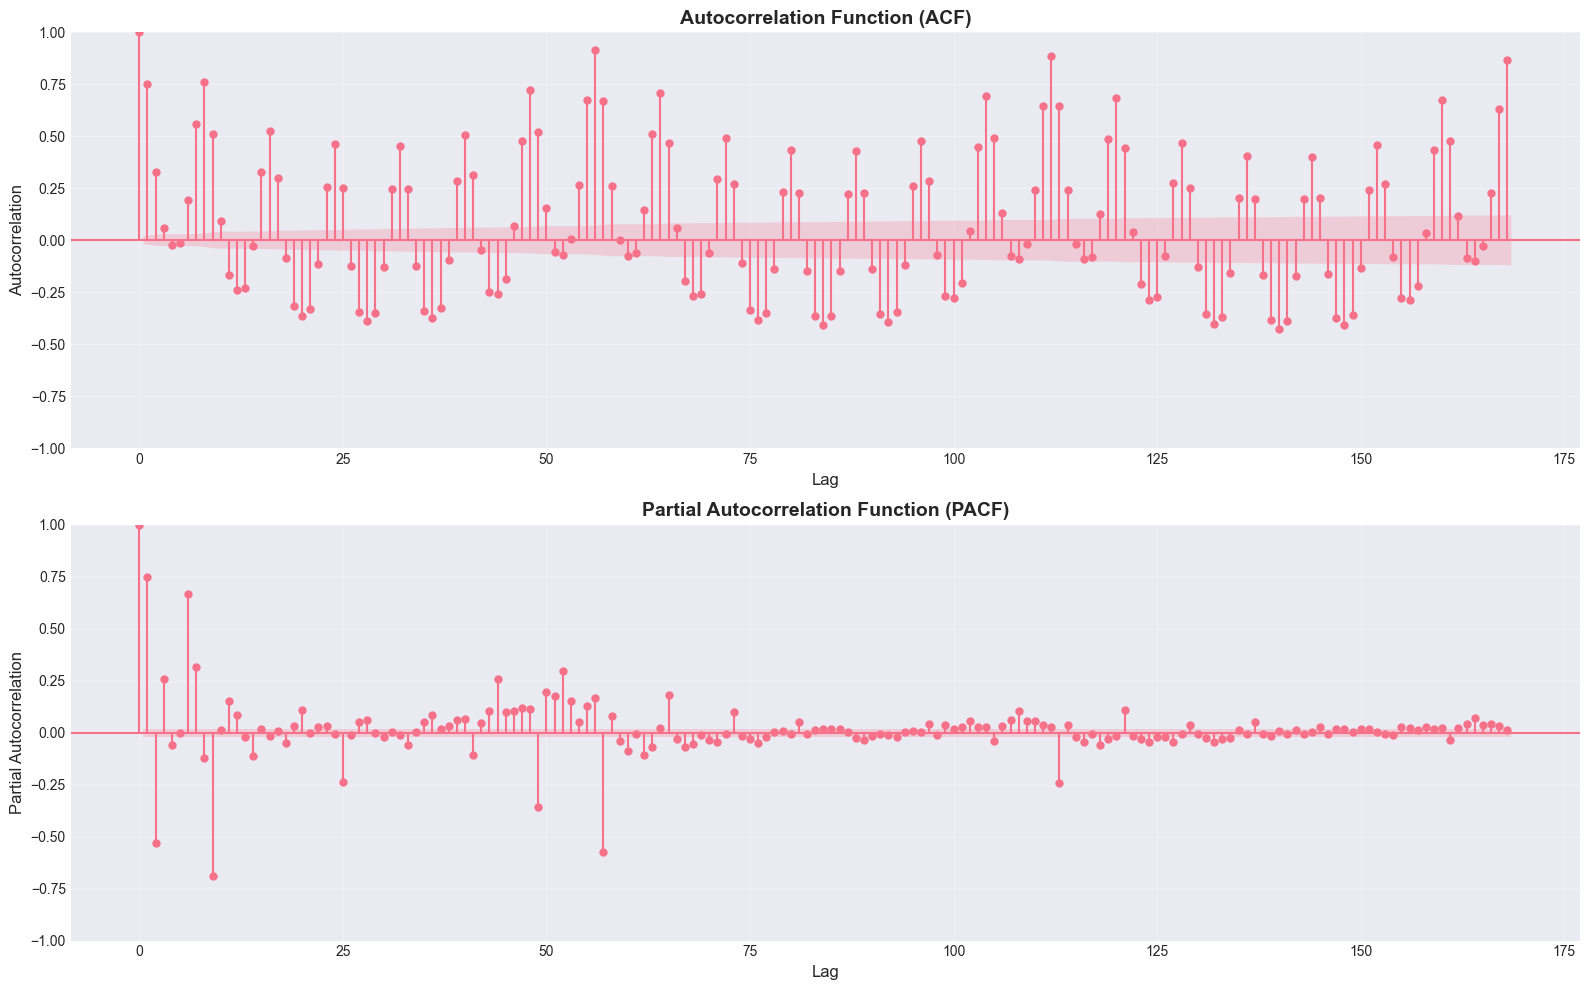


Significant ACF lags (first 20): [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Significant PACF lags (first 20): [0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 18, 19, 20, 22, 23, 25]

Key lags to consider:
   - Lag 1: ACF=0.7494, PACF=0.7494
   - Lag 24: ACF=0.4638, PACF=-0.0065
   - Lag 48: ACF=0.7212, PACF=0.1154
   - Lag 168: ACF=0.8689, PACF=0.0124



In [13]:
# STEP 7: Autocorrelation Analysis
print("="*80)
print("STEP 7: AUTOCORRELATION ANALYSIS")
print("="*80)

# Determine max lags based on resolution
if RESOLUTION == '60min':
    max_lags = 168  # 1 week
elif RESOLUTION == '30min':
    max_lags = 336  # 1 week
else:  # 15min
    max_lags = 672  # 1 week

# Sample if too large
if len(target) > 10000:
    sample_target = target.iloc[::max(1, len(target)//10000)]
else:
    sample_target = target

# Calculate autocorrelations
print(f"\nCalculating ACF and PACF (max_lags={max_lags})...")

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# ACF Plot
plot_acf(sample_target, lags=min(max_lags, len(sample_target)-1), ax=axes[0], alpha=0.05)
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=12)
axes[0].set_ylabel('Autocorrelation', fontsize=12)
axes[0].grid(alpha=0.3)

# PACF Plot
plot_pacf(sample_target, lags=min(max_lags, len(sample_target)-1), ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=12)
axes[1].set_ylabel('Partial Autocorrelation', fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'../saved_model_outputs/eda_outputs/step7_autocorrelation_{RESOLUTION}.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify significant lags
from statsmodels.tsa.stattools import acf, pacf

acf_values = acf(sample_target, nlags=min(max_lags, len(sample_target)-1), fft=True)
pacf_values = pacf(sample_target, nlags=min(max_lags, len(sample_target)-1), method='ywm')

# Find significant lags (outside confidence interval)
confidence_interval = 1.96 / np.sqrt(len(sample_target))
significant_acf_lags = np.where(np.abs(acf_values) > confidence_interval)[0]
significant_pacf_lags = np.where(np.abs(pacf_values) > confidence_interval)[0]

print(f"\nSignificant ACF lags (first 20): {significant_acf_lags[:20].tolist()}")
print(f"Significant PACF lags (first 20): {significant_pacf_lags[:20].tolist()}")

# Key lags for hourly data
key_lags = [1, 24, 48, 168] if RESOLUTION == '60min' else [1, 48, 96, 336] if RESOLUTION == '30min' else [1, 96, 192, 672]
print(f"\nKey lags to consider:")
for lag in key_lags:
    if lag < len(acf_values):
        print(f"   - Lag {lag}: ACF={acf_values[lag]:.4f}, PACF={pacf_values[lag]:.4f}")

print("\n" + "="*80)


---
# EDA STEP 8 — Calendar Effects

## Purpose
Analyze how calendar features (hour, day of week, holidays) affect electricity demand.

## What We Analyze:
1. Hour of day effects
2. Day of week effects
3. Weekday vs weekend
4. Holiday effects (if available)



In [14]:
# STEP 8: Calendar Effects
print("="*80)
print("STEP 8: CALENDAR EFFECTS")
print("="*80)

# Use df_seasonal from Step 3
if 'hour' not in df_seasonal.columns:
    df_seasonal = df.copy()
    df_seasonal['hour'] = df_seasonal.index.hour
    df_seasonal['day_of_week'] = df_seasonal.index.dayofweek

# Ensure is_weekend is a boolean
if 'is_weekend' in df_seasonal.columns:
    df_seasonal['is_weekend'] = df_seasonal['is_weekend'].astype(bool)
else:
    df_seasonal['is_weekend'] = df_seasonal.index.dayofweek >= 5

# 1. Weekday vs Weekend
print("\n1. Weekday vs Weekend Comparison:")
weekend_avg = df_seasonal[df_seasonal['is_weekend']]['target_load'].mean()
weekday_avg = df_seasonal[~df_seasonal['is_weekend']]['target_load'].mean()
print(f"   - Weekday average: {weekday_avg:,.2f} MW")
print(f"   - Weekend average: {weekend_avg:,.2f} MW")
print(f"   - Difference: {weekday_avg - weekend_avg:,.2f} MW ({((weekday_avg - weekend_avg)/weekday_avg*100):.2f}%)")

# 2. Holiday effects
if 'is_holiday' in df_seasonal.columns:
    print("\n2. Holiday Effects:")
    holiday_avg = df_seasonal[df_seasonal['is_holiday'] == 1]['target_load'].mean()
    non_holiday_avg = df_seasonal[df_seasonal['is_holiday'] == 0]['target_load'].mean()
    print(f"   - Holiday average: {holiday_avg:,.2f} MW")
    print(f"   - Non-holiday average: {non_holiday_avg:,.2f} MW")
    print(f"   - Difference: {non_holiday_avg - holiday_avg:,.2f} MW")
else:
    print("\n2. Holiday Effects: [INFO] Holiday column not found in dataset")

# 3. Day of week detailed analysis
print("\n3. Day of Week Detailed Analysis:")
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, day in enumerate(day_names):
    day_data = df_seasonal[df_seasonal['day_of_week'] == i]['target_load']
    print(f"   - {day:12s}: Mean={day_data.mean():,.2f} MW, Std={day_data.std():,.2f} MW")

print("\n" + "="*80)


STEP 8: CALENDAR EFFECTS

1. Weekday vs Weekend Comparison:
   - Weekday average: 58,872.83 MW
   - Weekend average: 47,785.15 MW
   - Difference: 11,087.69 MW (18.83%)

2. Holiday Effects:
   - Holiday average: nan MW
   - Non-holiday average: 55,697.94 MW
   - Difference: nan MW

3. Day of Week Detailed Analysis:
   - Monday      : Mean=57,668.33 MW, Std=10,377.34 MW
   - Tuesday     : Mean=59,463.54 MW, Std=9,282.15 MW
   - Wednesday   : Mean=59,843.14 MW, Std=9,074.86 MW
   - Thursday    : Mean=59,336.90 MW, Std=9,256.13 MW
   - Friday      : Mean=58,054.08 MW, Std=9,089.28 MW
   - Saturday    : Mean=49,725.85 MW, Std=6,166.05 MW
   - Sunday      : Mean=45,844.44 MW, Std=5,868.12 MW



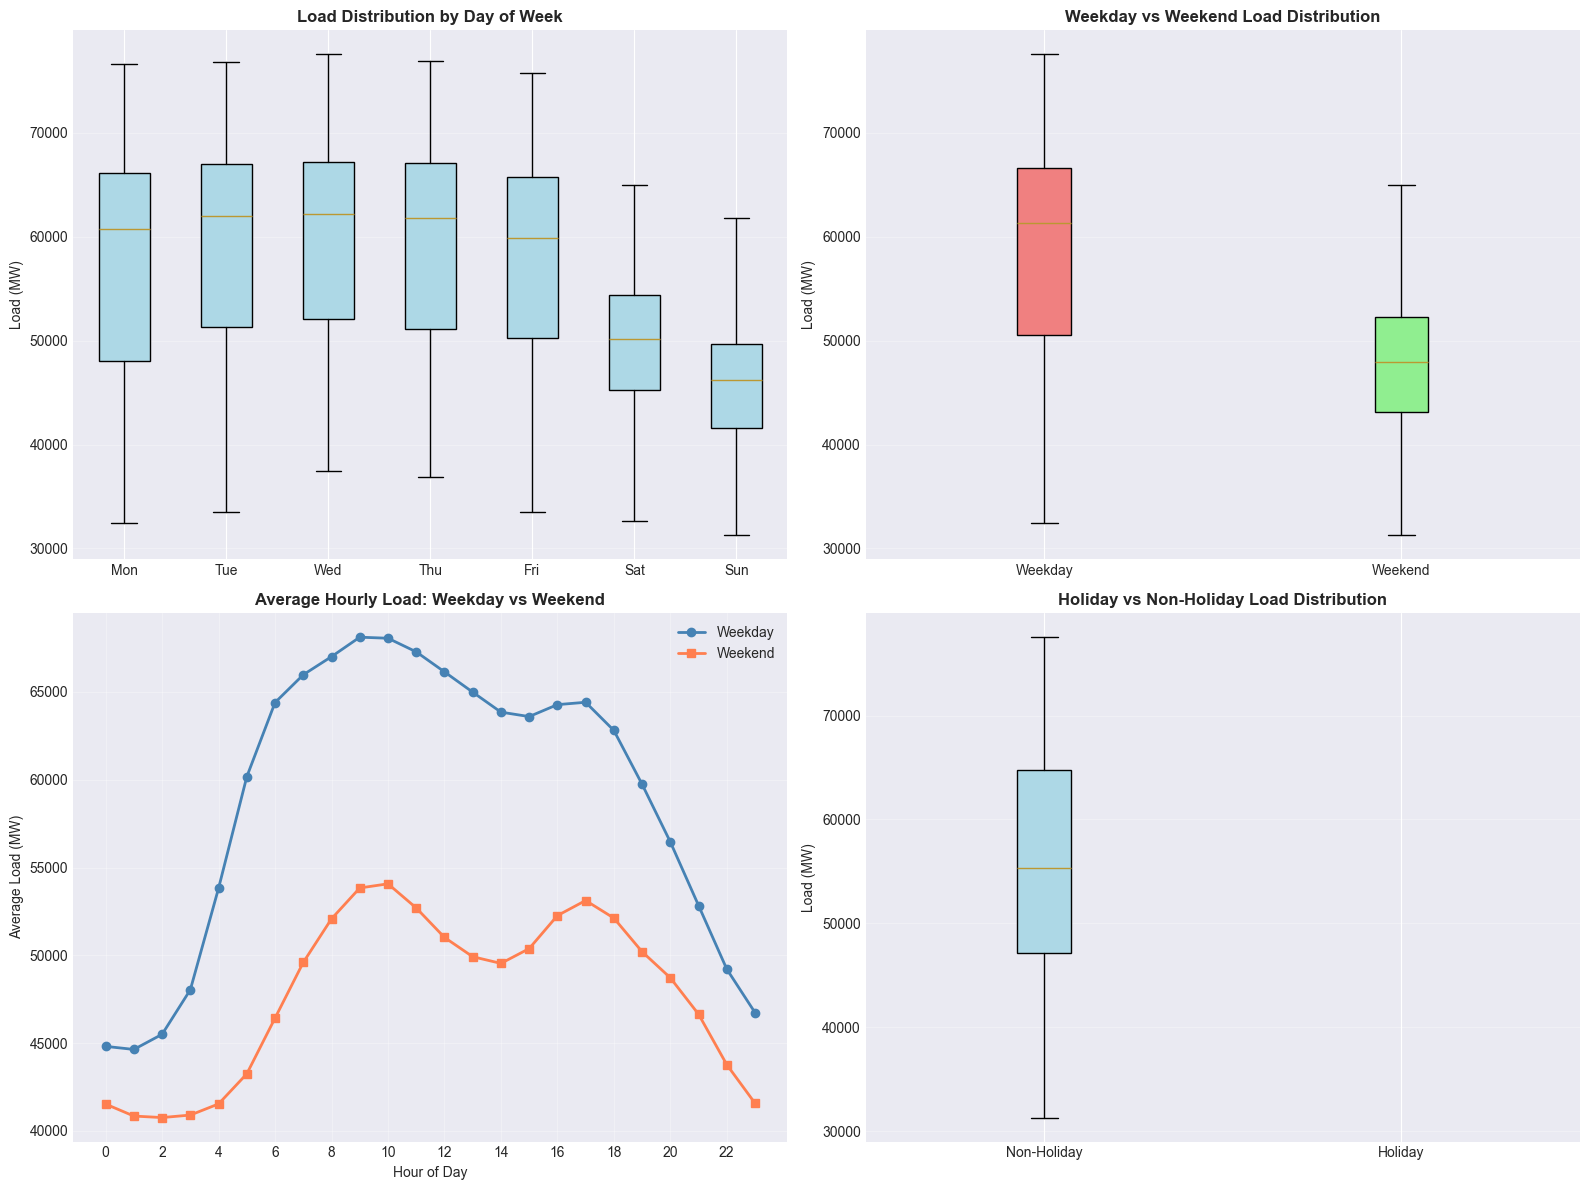

Step 8 visualizations saved!


In [15]:
# Visualizations for Calendar Effects
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Boxplot by day of week
day_data_list = [df_seasonal[df_seasonal['day_of_week'] == i]['target_load'].values for i in range(7)]
bp = axes[0, 0].boxplot(day_data_list, labels=[d[:3] for d in day_names], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[0, 0].set_title('Load Distribution by Day of Week', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Load (MW)', fontsize=10)
axes[0, 0].grid(alpha=0.3, axis='y')

# 2. Weekday vs Weekend comparison
weekend_data = df_seasonal[df_seasonal['is_weekend']]['target_load'].values
weekday_data = df_seasonal[~df_seasonal['is_weekend']]['target_load'].values
axes[0, 1].boxplot([weekday_data, weekend_data], labels=['Weekday', 'Weekend'], patch_artist=True)
axes[0, 1].patches[0].set_facecolor('lightcoral')
axes[0, 1].patches[1].set_facecolor('lightgreen')
axes[0, 1].set_title('Weekday vs Weekend Load Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Load (MW)', fontsize=10)
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Average hourly load by day type
hourly_weekday = df_seasonal[~df_seasonal['is_weekend']].groupby('hour')['target_load'].mean()
hourly_weekend = df_seasonal[df_seasonal['is_weekend']].groupby('hour')['target_load'].mean()
axes[1, 0].plot(hourly_weekday.index, hourly_weekday.values, marker='o', linewidth=2, label='Weekday', color='steelblue')
axes[1, 0].plot(hourly_weekend.index, hourly_weekend.values, marker='s', linewidth=2, label='Weekend', color='coral')
axes[1, 0].set_title('Average Hourly Load: Weekday vs Weekend', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Hour of Day', fontsize=10)
axes[1, 0].set_ylabel('Average Load (MW)', fontsize=10)
axes[1, 0].set_xticks(range(0, 24, 2))
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Holiday effects 
if 'is_holiday' in df_seasonal.columns:
    holiday_data = df_seasonal[df_seasonal['is_holiday'] == 1]['target_load'].values
    non_holiday_data = df_seasonal[df_seasonal['is_holiday'] == 0]['target_load'].values
    axes[1, 1].boxplot([non_holiday_data, holiday_data], labels=['Non-Holiday', 'Holiday'], patch_artist=True)
    axes[1, 1].patches[0].set_facecolor('lightblue')
    axes[1, 1].patches[1].set_facecolor('gold')
    axes[1, 1].set_title('Holiday vs Non-Holiday Load Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Load (MW)', fontsize=10)
    axes[1, 1].grid(alpha=0.3, axis='y')
else:
    axes[1, 1].text(0.5, 0.5, 'Holiday data not available', ha='center', va='center', fontsize=14)
    axes[1, 1].set_xticks([])
    axes[1, 1].set_yticks([])

plt.tight_layout()
plt.savefig(f'../saved_model_outputs/eda_outputs/step8_calendar_effects_{RESOLUTION}.png', dpi=300, bbox_inches='tight')
plt.show()

print("Step 8 visualizations saved!")


---
# Step 9: Weather Variables

Just added actual weather data to the dataset! Now I can look at:
- Temperature 
- Humidity
- Wind speed
- Solar radiation
- Cloud cover
- Precipitation





In [16]:
# Step 9: Looking at weather variables
print("="*80)
print("STEP 9: WEATHER VARIABLE EXPLORATION")
print("="*80)

# Finding all weather-related columns
weather_cols = []

# Weather Data
actual_weather_keywords = [
    'temperature_pop_wtd',
    'humidity_pop_wtd', 
    'wind_speed_pop_wtd',
    'solar_radiation_surface_pop_wtd',
    'solar_radiation_toa_pop_wtd',
    'cloud_cover_pop_wtd',
    'precipitation_pop_wtd'
]

for keyword in actual_weather_keywords:
    if keyword in df.columns:
        weather_cols.append(keyword)

# Also check for weather proxy columns 
if 'solar_proxy' in df.columns:
    weather_cols.append('solar_proxy')
if 'wind_proxy' in df.columns:
    weather_cols.append('wind_proxy')
if 'temp_proxy' in df.columns:
    weather_cols.append('temp_proxy')

# And generation columns can also act as weather proxies
gen_cols = [col for col in df.columns if 'generation' in col.lower() and 'actual' in col.lower()]
if len(gen_cols) > 0:
    # Use main generation columns
    main_solar = [col for col in gen_cols if 'solar' in col.lower() and 'DE_' in col and not any(x in col for x in ['50hertz', 'LU', 'amprion', 'tennet', 'transnet'])]
    main_wind = [col for col in gen_cols if 'wind' in col.lower() and 'DE_' in col and not any(x in col for x in ['50hertz', 'LU', 'amprion', 'tennet', 'transnet', 'offshore', 'onshore'])]
    
    if len(main_solar) > 0:
        weather_cols.append(main_solar[0])
    if len(main_wind) > 0:
        weather_cols.append(main_wind[0])

print(f"\nWeather-related columns found ({len(weather_cols)} total):")
print(f"  {weather_cols}")

# Which weather variables correlate most with load
print("\n1. Correlation with Target Load:")
correlations = {}
for col in weather_cols:
    if col in df.columns:
        corr = df[col].corr(df['target_load'])
        correlations[col] = corr
        print(f"   - {col}: {corr:.4f}")

# Sort by absolute correlation
sorted_corrs = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
print(f"\n   Top weather variable: {sorted_corrs[0][0]} (corr={sorted_corrs[0][1]:.4f})")

# Separate actual weather from proxies
actual_weather = [col for col in weather_cols if any(kw in col for kw in actual_weather_keywords)]
proxies = [col for col in weather_cols if col not in actual_weather]

if len(actual_weather) > 0:
    print(f"\n2. Actual Weather Variables ({len(actual_weather)}):")
    for col in actual_weather:
        if col in correlations:
            print(f"   - {col}: {correlations[col]:.4f}")

if len(proxies) > 0:
    print(f"\n3. Weather Proxies ({len(proxies)}):")
    for col in proxies:
        if col in correlations:
            print(f"   - {col}: {correlations[col]:.4f}")

# Basic statistics for actual weather variables
if len(actual_weather) > 0:
    print(f"\n4. Weather Variable Statistics:")
    for col in actual_weather[:3]:  # Top 3 actual weather variables
        if col in df.columns:
            print(f"\n   {col}:")
            print(f"      Mean: {df[col].mean():.2f}")
            print(f"      Std:  {df[col].std():.2f}")
            print(f"      Min:  {df[col].min():.2f}")
            print(f"      Max:  {df[col].max():.2f}")

print("\n" + "="*80)


STEP 9: WEATHER VARIABLE EXPLORATION

Weather-related columns found (5 total):
  ['solar_proxy', 'wind_proxy', 'temp_proxy', 'DE_solar_generation_actual', 'DE_wind_generation_actual']

1. Correlation with Target Load:
   - solar_proxy: 0.3427
   - wind_proxy: 0.0937
   - temp_proxy: 0.3081
   - DE_solar_generation_actual: 0.3427
   - DE_wind_generation_actual: 0.0956

   Top weather variable: solar_proxy (corr=0.3427)

3. Weather Proxies (5):
   - solar_proxy: 0.3427
   - wind_proxy: 0.0937
   - temp_proxy: 0.3081
   - DE_solar_generation_actual: 0.3427
   - DE_wind_generation_actual: 0.0956



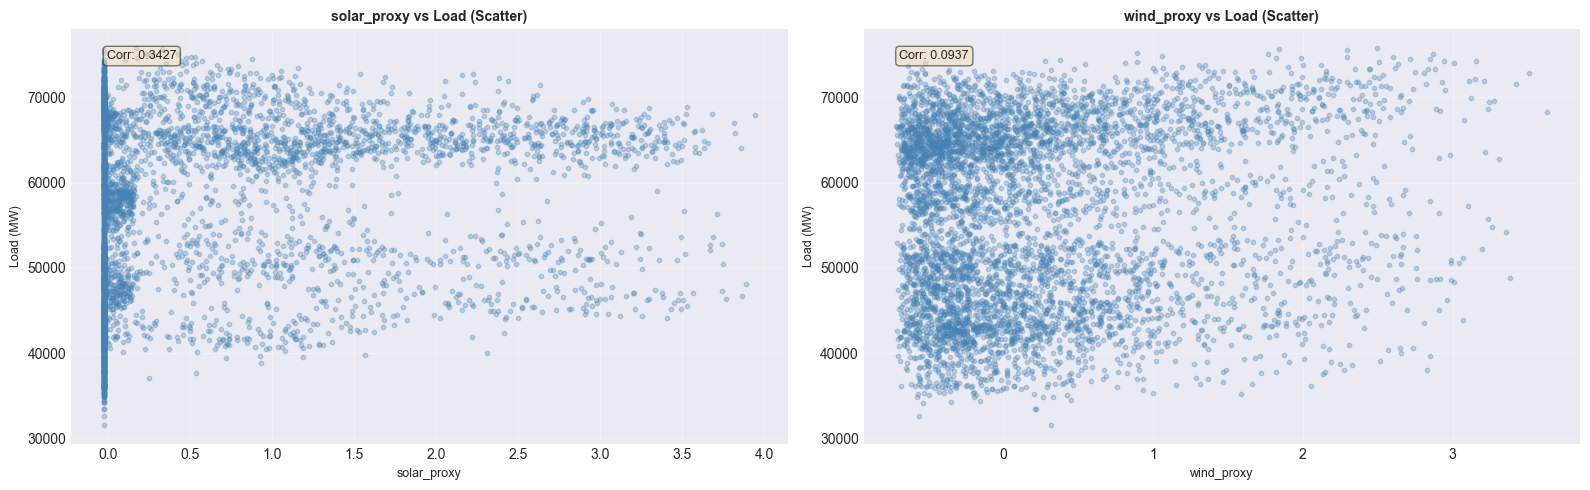

Step 9 visualizations saved! (2 weather variables shown)


In [17]:
# Visualizations for Step 9
if len(weather_cols) > 0:
    # Prioritize actual weather variables for visualization
    actual_weather_viz = [col for col in weather_cols if any(kw in col for kw in ['temperature', 'humidity', 'wind_speed', 'solar_radiation', 'cloud_cover', 'precipitation'])]
    proxy_viz = [col for col in weather_cols if col not in actual_weather_viz]
    
    # Combine: actual weather first, then proxies (up to 6 total)
    viz_cols = (actual_weather_viz[:4] + proxy_viz[:2])[:6]
    
    n_plots = min(len(viz_cols), 6)
    if n_plots > 0:
        # Create subplots: 3 rows x 2 cols for up to 6 variables
        n_rows = min(3, (n_plots + 1) // 2)
        fig, axes = plt.subplots(n_rows, 2, figsize=(16, 5*n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for idx, col in enumerate(viz_cols):
            if col not in df.columns:
                continue
                
            row = idx // 2
            col_idx = idx % 2
            
            # Sample for scatter plot if too large
            sample_size = min(5000, len(df))
            sample_df = df.iloc[::max(1, len(df)//sample_size)]
            
            # Scatter plot
            axes[row, col_idx].scatter(sample_df[col], sample_df['target_load'], alpha=0.3, s=10, color='steelblue')
            axes[row, col_idx].set_xlabel(col, fontsize=9)
            axes[row, col_idx].set_ylabel('Load (MW)', fontsize=9)
            axes[row, col_idx].set_title(f'{col} vs Load (Scatter)', fontsize=10, fontweight='bold')
            axes[row, col_idx].grid(alpha=0.3)
            
            # Add correlation text
            if col in correlations:
                corr = correlations[col]
                axes[row, col_idx].text(0.05, 0.95, f'Corr: {corr:.4f}', 
                                      transform=axes[row, col_idx].transAxes, 
                                      verticalalignment='top', fontsize=9,
                                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Hide unused subplots
        for idx in range(n_plots, n_rows * 2):
            row = idx // 2
            col_idx = idx % 2
            axes[row, col_idx].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'../saved_model_outputs/eda_outputs/step9_weather_exploration_{RESOLUTION}.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Step 9 visualizations saved! ({n_plots} weather variables shown)")
    else:
        print("[INFO] No weather columns available for visualization")
else:
    print("[INFO] No weather columns found for visualization")


---
# EDA STEP 10 — Lagged Relationship Analysis

## Purpose
Analyze relationships between target variable and its lagged values, and lagged weather variables.

## What We Check:
1. Load(t) vs Load(t-1, t-24, t-168)
2. Weather variable lag effects
3. Optimal lag selection

## Why This Matters:
- Choose meaningful lag features
- Decide LSTM window length
- Inform feature engineering


In [18]:
# STEP 10: Lagged Relationship Analysis
print("="*80)
print("STEP 10: LAGGED RELATIONSHIP ANALYSIS")
print("="*80)

# Key lags to analyze
if RESOLUTION == '60min':
    key_lags = [1, 6, 12, 24, 48, 168]  # 1h, 6h, 12h, 1d, 2d, 1w
elif RESOLUTION == '30min':
    key_lags = [2, 12, 24, 48, 96, 336]  # 1h, 6h, 12h, 1d, 2d, 1w
else:  # 15min
    key_lags = [4, 24, 48, 96, 192, 672]  # 1h, 6h, 12h, 1d, 2d, 1w

print(f"\nAnalyzing key lags: {key_lags}")

# Correlation with lagged target
print("\n1. Target Load Autocorrelations (at key lags):")
lag_correlations = {}
for lag in key_lags:
    if lag < len(target):
        lagged = target.shift(lag)
        corr = target.corr(lagged)
        lag_correlations[lag] = corr
        print(f"   - Lag {lag:3d}: {corr:.4f}")

# Find best lag
best_lag = max(lag_correlations.items(), key=lambda x: abs(x[1]))
print(f"\n   Best immediate lag: {best_lag[0]} (corr={best_lag[1]:.4f})")

# Check lagged weather variables if available
if len(weather_cols) > 0:
    print("\n2. Weather Variable Lag Effects:")
    for col in weather_cols[:2]:  # Top 2 weather variables
        if col in df.columns:
            print(f"\n   {col}:")
            for lag in [1, 24] if RESOLUTION == '60min' else [2, 48] if RESOLUTION == '30min' else [4, 96]:
                if lag < len(df):
                    lagged_weather = df[col].shift(lag)
                    corr = df['target_load'].corr(lagged_weather)
                    print(f"     - Lag {lag}: {corr:.4f}")

print("\n" + "="*80)


STEP 10: LAGGED RELATIONSHIP ANALYSIS

Analyzing key lags: [1, 6, 12, 24, 48, 168]

1. Target Load Autocorrelations (at key lags):
   - Lag   1: 0.9658
   - Lag   6: 0.3377
   - Lag  12: -0.0332
   - Lag  24: 0.7564
   - Lag  48: 0.5185
   - Lag 168: 0.9173

   Best immediate lag: 1 (corr=0.9658)

2. Weather Variable Lag Effects:

   solar_proxy:
     - Lag 1: 0.3248
     - Lag 24: 0.3521

   wind_proxy:
     - Lag 1: 0.0862
     - Lag 24: 0.0732



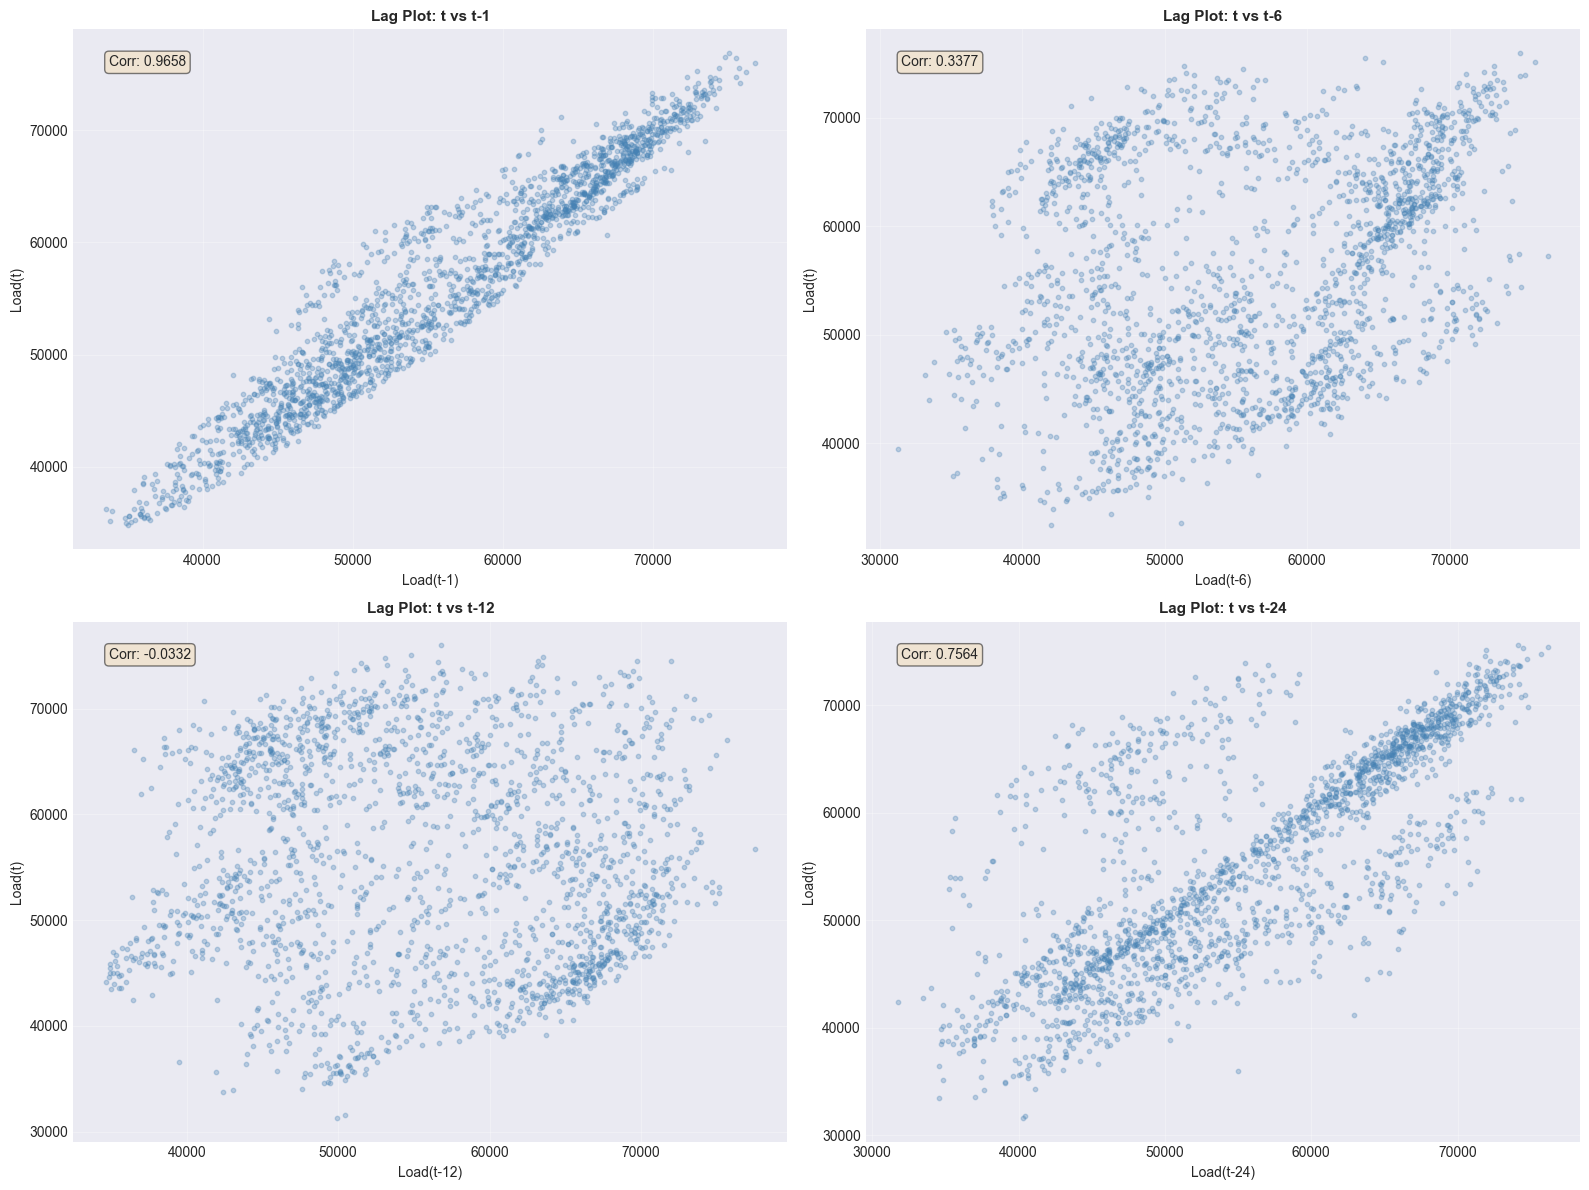

Step 8 visualizations saved!


In [19]:
# Visualizations for Step 10
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Lag plot for key lags
for idx, lag in enumerate(key_lags[:4]):
    if lag < len(target):
        row = idx // 2
        col = idx % 2
        lagged = target.shift(lag)
        sample_size = min(2000, len(target))
        sample_indices = np.random.choice(len(target), sample_size, replace=False)
        axes[row, col].scatter(lagged.iloc[sample_indices], target.iloc[sample_indices], 
                              alpha=0.3, s=10, color='steelblue')
        axes[row, col].set_xlabel(f'Load(t-{lag})', fontsize=10)
        axes[row, col].set_ylabel('Load(t)', fontsize=10)
        axes[row, col].set_title(f'Lag Plot: t vs t-{lag}', fontsize=11, fontweight='bold')
        axes[row, col].grid(alpha=0.3)
        
        # Add correlation text
        corr = lag_correlations.get(lag, 0)
        axes[row, col].text(0.05, 0.95, f'Corr: {corr:.4f}', 
                          transform=axes[row, col].transAxes, 
                          verticalalignment='top', fontsize=10,
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f'../saved_model_outputs/eda_outputs/step10_lagged_relationships_{RESOLUTION}.png', dpi=300, bbox_inches='tight')
plt.show()

print("Step 8 visualizations saved!")


---
# Step 11: Peak Loads

We want to identify when peak loads happen (the highest demand periods). This is important because:
- These are the most critical times to forecast accurately
- The grid needs to handle these peaks
- We should evaluate my model's performance on peak vs normal periods




In [20]:
# Step 11: Finding peak loads
print("="*80)
print("STEP 11: PEAK LOAD IDENTIFICATION")
print("="*80)

# Using 90th percentile as the threshold for "peak" loads
peak_threshold = target.quantile(0.90)
print(f"\nPeak Load Threshold (90th percentile): {peak_threshold:,.2f} MW")

# Identify peak periods
is_peak = target >= peak_threshold
peak_count = is_peak.sum()
peak_percentage = (peak_count / len(target)) * 100

print(f"\n1. Peak Load Statistics:")
print(f"   - Number of peak periods: {peak_count:,} ({peak_percentage:.2f}% of data)")
print(f"   - Average peak load: {target[is_peak].mean():,.2f} MW")
print(f"   - Maximum load: {target.max():,.2f} MW")
print(f"   - Minimum peak load: {target[is_peak].min():,.2f} MW")

# Analyze when peaks occur
# Make sure df_seasonal has the columns we need
if 'hour' not in df_seasonal.columns:
    df_seasonal = df.copy()
    df_seasonal['hour'] = df_seasonal.index.hour
    df_seasonal['day_of_week'] = df_seasonal.index.dayofweek
    df_seasonal['month'] = df_seasonal.index.month

# Always add is_peak column (in case df_seasonal already existed)
df_seasonal['is_peak'] = is_peak

print("\n2. Peak Occurrence Analysis:")
# By hour
peak_by_hour = df_seasonal[df_seasonal['is_peak']].groupby('hour').size()
print(f"   - Most common peak hour: {peak_by_hour.idxmax()} ({peak_by_hour.max()} occurrences)")

# By day of week
peak_by_dow = df_seasonal[df_seasonal['is_peak']].groupby('day_of_week').size()
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
print(f"   - Most common peak day: {day_names[peak_by_dow.idxmax()]} ({peak_by_dow.max()} occurrences)")

# By month
peak_by_month = df_seasonal[df_seasonal['is_peak']].groupby('month').size()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
print(f"   - Most common peak month: {month_names[peak_by_month.idxmax()-1]} ({peak_by_month.max()} occurrences)")

# Check if weather is different during peak loads
if 'weather_cols' in locals() and len(weather_cols) > 0:
    print("\n3. Weather Conditions During Peak Loads:")
    # Looking at temperature, humidity, wind speed first (these seem most relevant)
    key_weather = [col for col in weather_cols if any(kw in col.lower() for kw in ['temperature', 'humidity', 'wind_speed'])]
    if len(key_weather) == 0:
        key_weather = weather_cols[:3]  # If those aren't available, just use first 3
    
    for col in key_weather[:3]:  # Analyze top 3 weather variables
        if col in df.columns:
            peak_weather = df.loc[is_peak, col]
            non_peak_weather = df.loc[~is_peak, col]
            
            print(f"\n   {col}:")
            print(f"      Peak periods - Mean: {peak_weather.mean():.2f}, Median: {peak_weather.median():.2f}")
            print(f"      Non-peak periods - Mean: {non_peak_weather.mean():.2f}, Median: {non_peak_weather.median():.2f}")
            print(f"      Difference: {peak_weather.mean() - non_peak_weather.mean():.2f}")

print("\n" + "="*80)


STEP 11: PEAK LOAD IDENTIFICATION

Peak Load Threshold (90th percentile): 68,855.00 MW

1. Peak Load Statistics:
   - Number of peak periods: 3,272 (10.01% of data)
   - Average peak load: 71,034.66 MW
   - Maximum load: 77,549.00 MW
   - Minimum peak load: 68,855.00 MW

2. Peak Occurrence Analysis:
   - Most common peak hour: 9 (462 occurrences)
   - Most common peak day: Wednesday (759 occurrences)
   - Most common peak month: Jan (740 occurrences)

3. Weather Conditions During Peak Loads:

   solar_proxy:
      Peak periods - Mean: 0.63, Median: 0.34
      Non-peak periods - Mean: 0.59, Median: -0.02
      Difference: 0.05

   wind_proxy:
      Peak periods - Mean: 0.64, Median: 0.38
      Non-peak periods - Mean: 0.20, Median: -0.03
      Difference: 0.44

   temp_proxy:
      Peak periods - Mean: 0.60, Median: 0.16
      Non-peak periods - Mean: 0.66, Median: -0.01
      Difference: -0.06



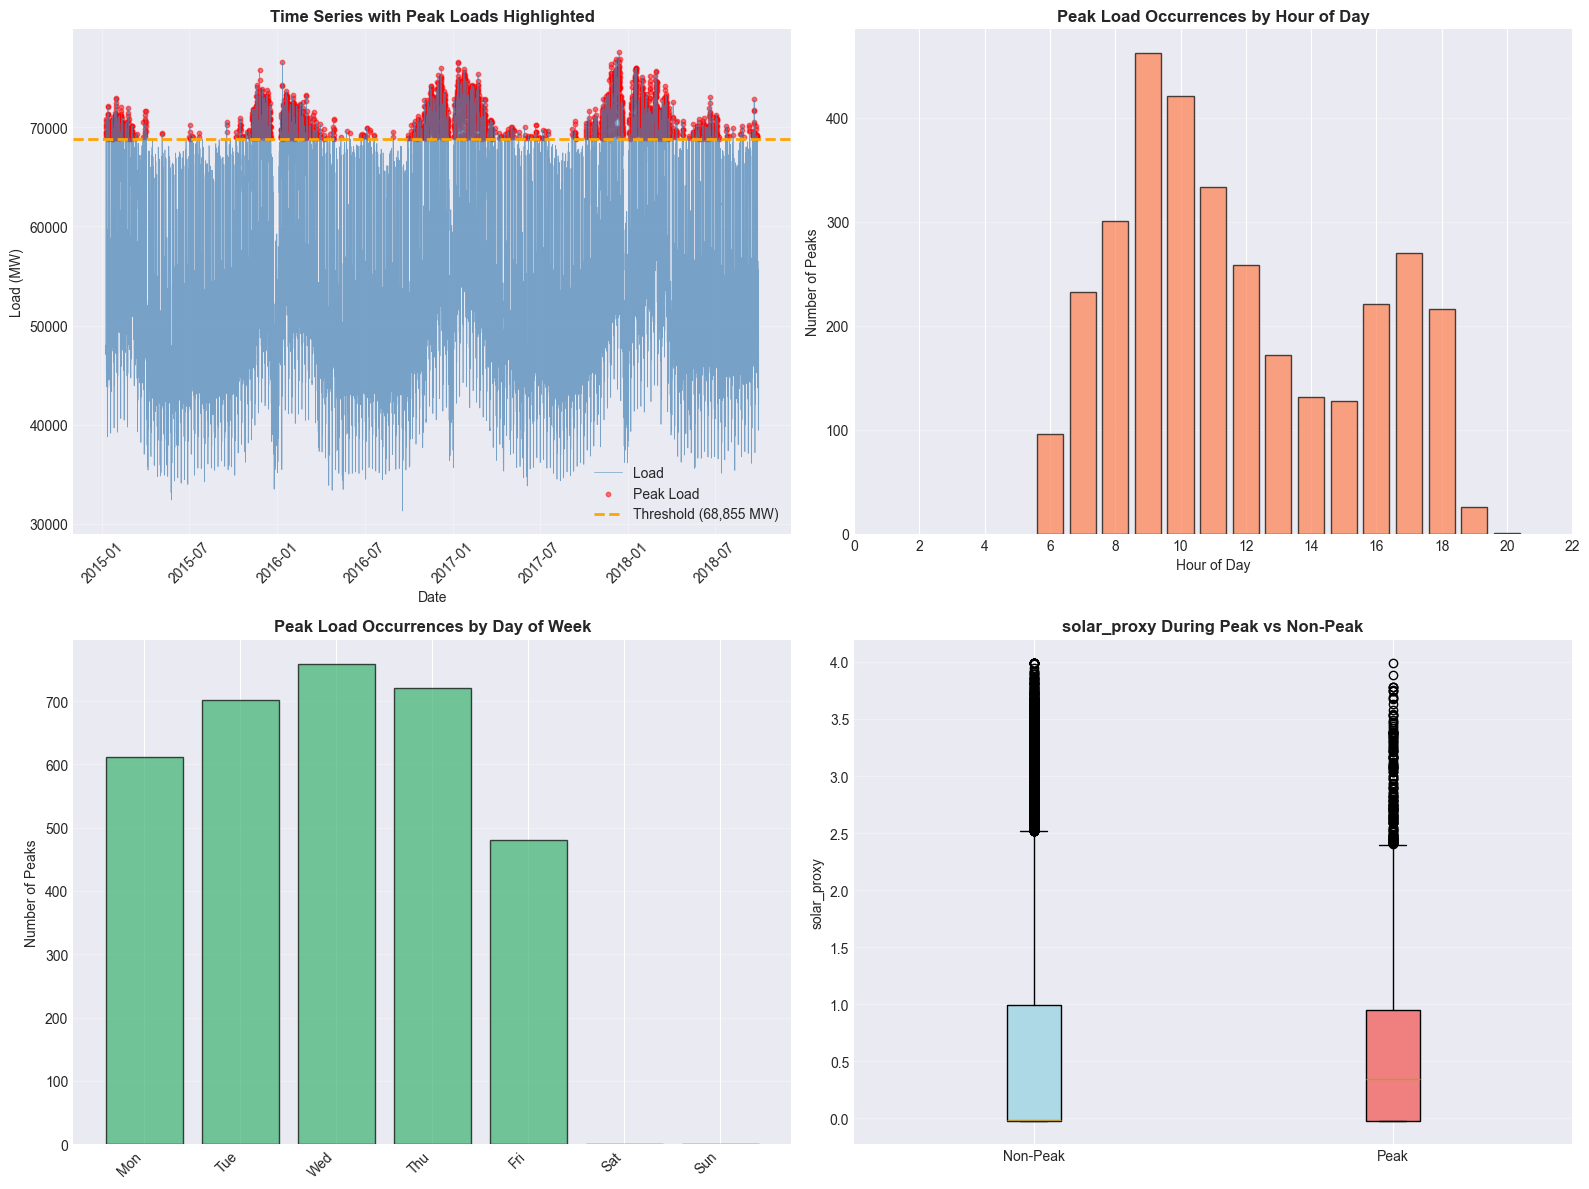

Step 11 visualizations saved!


In [21]:
# Visualizations for Step 11
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Time series with peaks highlighted
axes[0, 0].plot(df.index, target.values, linewidth=0.5, alpha=0.7, color='steelblue', label='Load')
axes[0, 0].scatter(df.index[is_peak], target[is_peak], color='red', s=10, alpha=0.5, label='Peak Load')
axes[0, 0].axhline(y=peak_threshold, color='orange', linestyle='--', linewidth=2, label=f'Threshold ({peak_threshold:,.0f} MW)')
axes[0, 0].set_title('Time Series with Peak Loads Highlighted', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date', fontsize=10)
axes[0, 0].set_ylabel('Load (MW)', fontsize=10)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Peak distribution by hour
peak_by_hour = df_seasonal[df_seasonal['is_peak']].groupby('hour').size()
axes[0, 1].bar(peak_by_hour.index, peak_by_hour.values, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Peak Load Occurrences by Hour of Day', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Hour of Day', fontsize=10)
axes[0, 1].set_ylabel('Number of Peaks', fontsize=10)
axes[0, 1].set_xticks(range(0, 24, 2))
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Peak distribution by day of week
peak_by_dow = df_seasonal[df_seasonal['is_peak']].groupby('day_of_week').size()
# Make sure we have all 7 days 
# day_names should already be defined above, but just in case:
if 'day_names' not in locals():
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Create a full series with all 7 days (0-6), then update with actual peak counts
peak_by_dow_full = pd.Series(0, index=range(7))
# Update with actual values where they exist
for day_idx in range(7):
    if day_idx in peak_by_dow.index:
        peak_by_dow_full.iloc[day_idx] = peak_by_dow.loc[day_idx]
axes[1, 0].bar(range(7), peak_by_dow_full.values, color='mediumseagreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels([d[:3] for d in day_names], rotation=45, ha='right')
axes[1, 0].set_title('Peak Load Occurrences by Day of Week', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Peaks', fontsize=10)
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Peak vs Non-Peak comparison
if 'weather_cols' in locals() and len(weather_cols) > 0:
    # Show weather comparison during peaks
    key_weather = [col for col in weather_cols if 'temperature' in col.lower()]
    if len(key_weather) == 0:
        key_weather = [col for col in weather_cols if any(kw in col.lower() for kw in ['humidity', 'wind_speed'])]
    if len(key_weather) == 0:
        key_weather = weather_cols[:1]
    
    if len(key_weather) > 0 and key_weather[0] in df.columns:
        weather_col = key_weather[0]
        peak_weather_data = df.loc[is_peak, weather_col].values
        non_peak_weather_data = df.loc[~is_peak, weather_col].values
        axes[1, 1].boxplot([non_peak_weather_data, peak_weather_data], 
                          labels=['Non-Peak', 'Peak'], patch_artist=True)
        axes[1, 1].patches[0].set_facecolor('lightblue')
        axes[1, 1].patches[1].set_facecolor('lightcoral')
        axes[1, 1].set_title(f'{weather_col} During Peak vs Non-Peak', fontsize=12, fontweight='bold')
        axes[1, 1].set_ylabel(weather_col, fontsize=10)
        axes[1, 1].grid(alpha=0.3, axis='y')
    else:
        # Fallback to load comparison
        peak_data = target[is_peak].values
        non_peak_data = target[~is_peak].values
        axes[1, 1].boxplot([non_peak_data, peak_data], labels=['Non-Peak', 'Peak'], patch_artist=True)
        axes[1, 1].patches[0].set_facecolor('lightblue')
        axes[1, 1].patches[1].set_facecolor('lightcoral')
        axes[1, 1].set_title('Peak vs Non-Peak Load Distribution', fontsize=12, fontweight='bold')
        axes[1, 1].set_ylabel('Load (MW)', fontsize=10)
        axes[1, 1].grid(alpha=0.3, axis='y')
else:
    # Original load comparison
    peak_data = target[is_peak].values
    non_peak_data = target[~is_peak].values
    axes[1, 1].boxplot([non_peak_data, peak_data], labels=['Non-Peak', 'Peak'], patch_artist=True)
    axes[1, 1].patches[0].set_facecolor('lightblue')
    axes[1, 1].patches[1].set_facecolor('lightcoral')
    axes[1, 1].set_title('Peak vs Non-Peak Load Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Load (MW)', fontsize=10)
    axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'../saved_model_outputs/eda_outputs/step11_peak_load_{RESOLUTION}.png', dpi=300, bbox_inches='tight')
plt.show()

print("Step 11 visualizations saved!")


---
# EDA STEP 12 — Error Sensitivity Preview

## Purpose
Preview forecast error patterns using a simple baseline model to understand where models struggle.

## What We Analyze:
1. Naive forecast errors
2. Errors during peak vs normal hours
3. Variance of errors




In [22]:
# STEP 12: Error Sensitivity Preview
print("="*80)
print("STEP 12: ERROR SENSITIVITY PREVIEW")
print("="*80)

# Simple naive forecast: use previous value
naive_forecast = target.shift(1)
errors = target - naive_forecast
errors = errors.dropna()

print("\n1. Naive Forecast Error Statistics:")
print(f"   - MAE: {mean_absolute_error(target[1:], naive_forecast[1:].dropna()):,.2f} MW")
print(f"   - RMSE: {np.sqrt(mean_squared_error(target[1:], naive_forecast[1:].dropna())):,.2f} MW")
print(f"   - Mean Error: {errors.mean():,.2f} MW")
print(f"   - Std Error: {errors.std():,.2f} MW")

# Errors during peak vs non-peak
if 'is_peak' in df_seasonal.columns:
    peak_errors = errors[df_seasonal.loc[errors.index, 'is_peak']]
    non_peak_errors = errors[~df_seasonal.loc[errors.index, 'is_peak']]
    
    print("\n2. Error Comparison: Peak vs Non-Peak Hours:")
    print(f"   - Peak hours MAE: {np.abs(peak_errors).mean():,.2f} MW")
    print(f"   - Non-peak hours MAE: {np.abs(non_peak_errors).mean():,.2f} MW")
    print(f"   - Peak hours RMSE: {np.sqrt((peak_errors**2).mean()):,.2f} MW")
    print(f"   - Non-peak hours RMSE: {np.sqrt((non_peak_errors**2).mean()):,.2f} MW")
    print(f"   - Error ratio (Peak/Non-Peak): {(np.abs(peak_errors).mean() / np.abs(non_peak_errors).mean()):.2f}x")

print("\n" + "="*80)


STEP 12: ERROR SENSITIVITY PREVIEW

1. Naive Forecast Error Statistics:
   - MAE: 1,981.79 MW
   - RMSE: 2,621.54 MW
   - Mean Error: -0.18 MW
   - Std Error: 2,621.58 MW

2. Error Comparison: Peak vs Non-Peak Hours:
   - Peak hours MAE: 1,260.65 MW
   - Non-peak hours MAE: 2,062.01 MW
   - Peak hours RMSE: 1,785.09 MW
   - Non-peak hours RMSE: 2,698.61 MW
   - Error ratio (Peak/Non-Peak): 0.61x



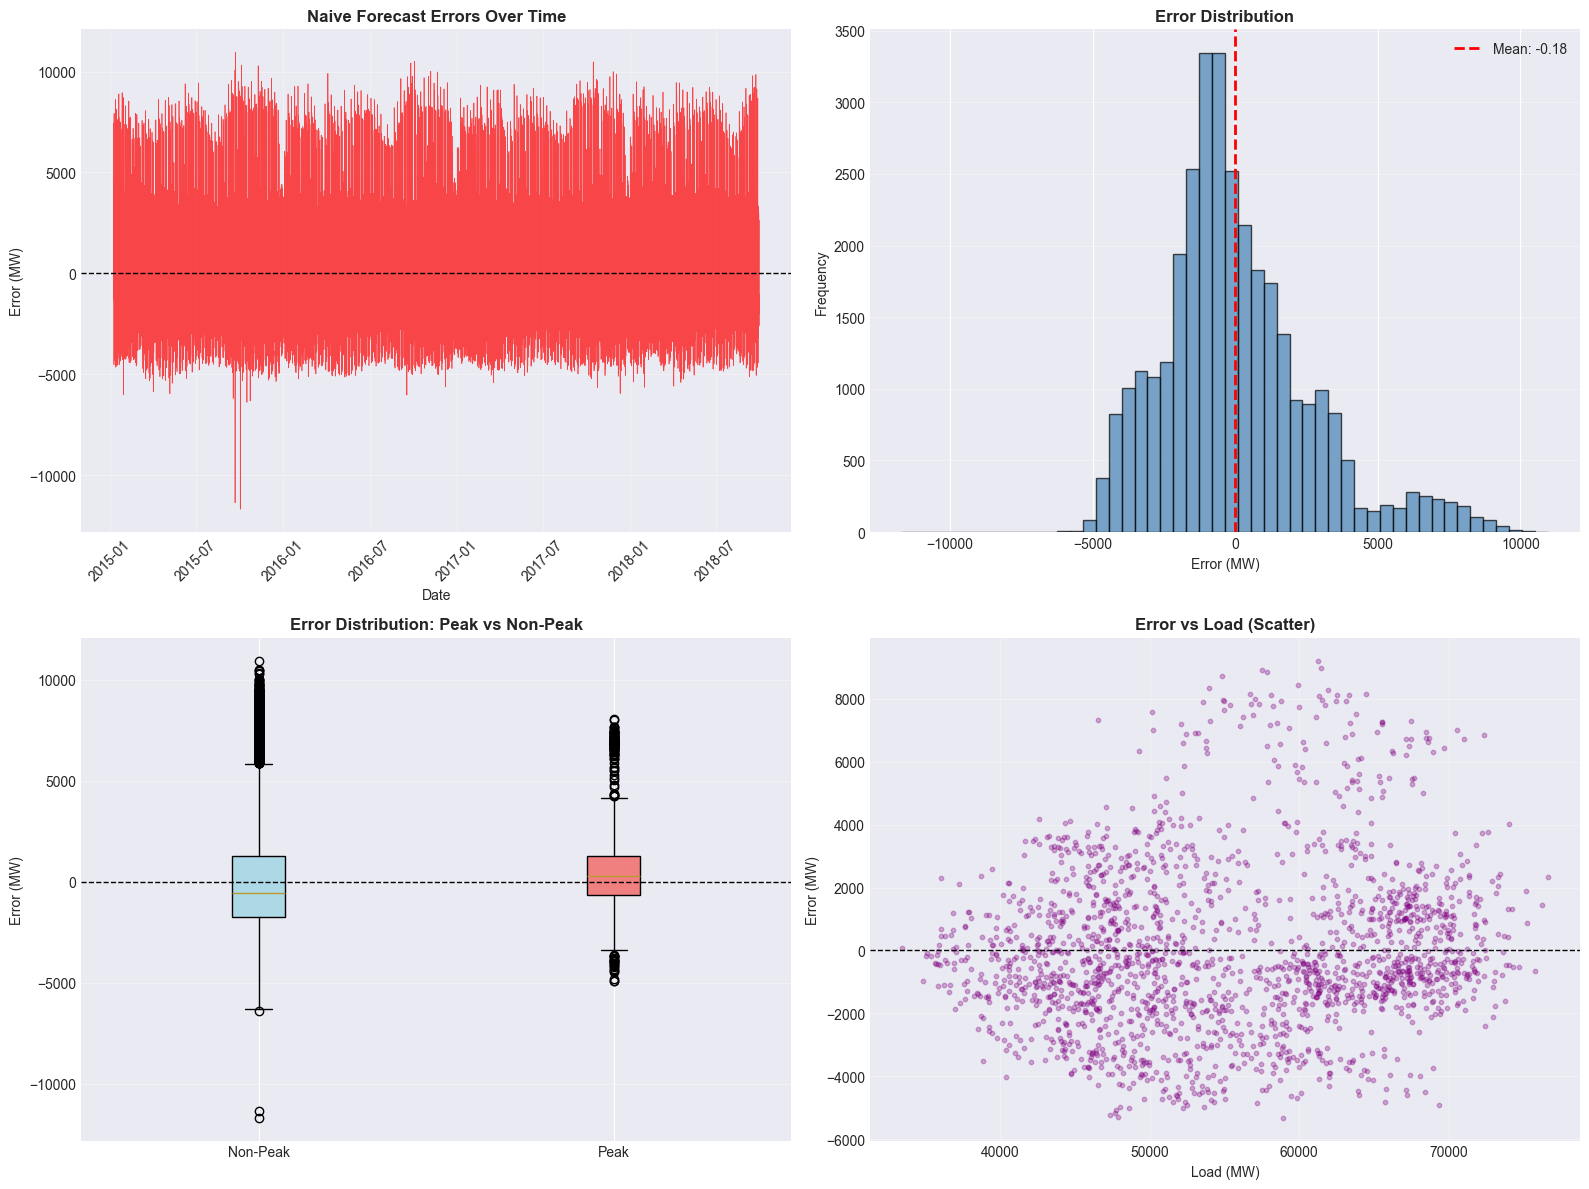

Step 12 visualizations saved!


In [23]:
# Visualizations for Step 12
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Error time series
axes[0, 0].plot(errors.index, errors.values, linewidth=0.5, alpha=0.7, color='red')
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 0].set_title('Naive Forecast Errors Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date', fontsize=10)
axes[0, 0].set_ylabel('Error (MW)', fontsize=10)
axes[0, 0].grid(alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Error distribution
axes[0, 1].hist(errors.values, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 1].axvline(errors.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {errors.mean():,.2f}')
axes[0, 1].set_title('Error Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Error (MW)', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Peak vs Non-Peak error comparison
if 'is_peak' in df_seasonal.columns and len(peak_errors) > 0:
    axes[1, 0].boxplot([non_peak_errors.values, peak_errors.values], 
                       labels=['Non-Peak', 'Peak'], patch_artist=True)
    axes[1, 0].patches[0].set_facecolor('lightblue')
    axes[1, 0].patches[1].set_facecolor('lightcoral')
    axes[1, 0].set_title('Error Distribution: Peak vs Non-Peak', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Error (MW)', fontsize=10)
    axes[1, 0].grid(alpha=0.3, axis='y')
    axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)

# 4. Error vs Load scatter
sample_size = min(2000, len(errors))
sample_indices = np.random.choice(len(errors), sample_size, replace=False)
axes[1, 1].scatter(target.loc[errors.index].iloc[sample_indices], 
                  errors.iloc[sample_indices], alpha=0.3, s=10, color='purple')
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_title('Error vs Load (Scatter)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Load (MW)', fontsize=10)
axes[1, 1].set_ylabel('Error (MW)', fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'../saved_model_outputs/eda_outputs/step12_error_sensitivity_{RESOLUTION}.png', dpi=300, bbox_inches='tight')
plt.show()

print("Step 12 visualizations saved!")


---
# EDA STEP 13 — Multicollinearity Check

## Purpose
Identify highly correlated features to avoid redundant inputs in LSTM models.

## What We Analyze:
1. Correlation matrix among features
2. Highly correlated weather variables
3. VIF scores (optional)

## Why This Matters:
- Feature selection for LSTM
- Avoid redundant inputs
- Improve model efficiency


In [24]:
# STEP 13: Multicollinearity Check
print("="*80)
print("STEP 13: MULTICOLLINEARITY CHECK")
print("="*80)

# Select numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'target_load' in numeric_cols:
    numeric_cols.remove('target_load')

# Limit to top features for correlation matrix
if len(numeric_cols) > 50:
    # Select most important features
    correlations_with_target = df[numeric_cols].corrwith(df['target_load']).abs().sort_values(ascending=False)
    top_features = correlations_with_target.head(50).index.tolist()
    numeric_cols = top_features
    print(f"\n[INFO] Limiting to top 50 features by correlation with target")

# Calculate correlation matrix
print(f"\nCalculating correlation matrix for {len(numeric_cols)} features...")
corr_matrix = df[numeric_cols].corr()

# Find highly correlated pairs
high_corr_pairs = []
threshold = 0.8
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) >= threshold:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_val
            ))

print(f"\n1. Highly Correlated Feature Pairs (|correlation| >= {threshold}):")
if len(high_corr_pairs) > 0:
    high_corr_pairs_sorted = sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)
    print(f"   - Found {len(high_corr_pairs_sorted)} highly correlated pairs")
    print(f"   - Top 10 pairs:")
    for feat1, feat2, corr in high_corr_pairs_sorted[:10]:
        print(f"     * {feat1} <-> {feat2}: {corr:.4f}")
else:
    print(f"   - No highly correlated pairs found (threshold={threshold})")

print("\n" + "="*80)


STEP 13: MULTICOLLINEARITY CHECK

[INFO] Limiting to top 50 features by correlation with target

Calculating correlation matrix for 50 features...

1. Highly Correlated Feature Pairs (|correlation| >= 0.8):
   - Found 150 highly correlated pairs
   - Top 10 pairs:
     * target_load_same_hour_last_week <-> target_load_lag_168: 1.0000
     * DE_solar_generation_actual <-> solar_proxy: 1.0000
     * DE_wind_onshore_generation_actual <-> wind_proxy: 1.0000
     * target_load_rolling_mean_3 <-> target_load_lag_1: 0.9986
     * DE_solar_generation_actual <-> DE_tennet_solar_generation_actual: 0.9943
     * solar_proxy <-> DE_tennet_solar_generation_actual: 0.9943
     * DE_wind_generation_actual <-> DE_wind_onshore_generation_actual: 0.9925
     * DE_wind_generation_actual <-> wind_proxy: 0.9925
     * target_load_ema_6 <-> target_load_rolling_mean_6: 0.9889
     * DE_solar_generation_actual <-> DE_amprion_solar_generation_actual: 0.9851



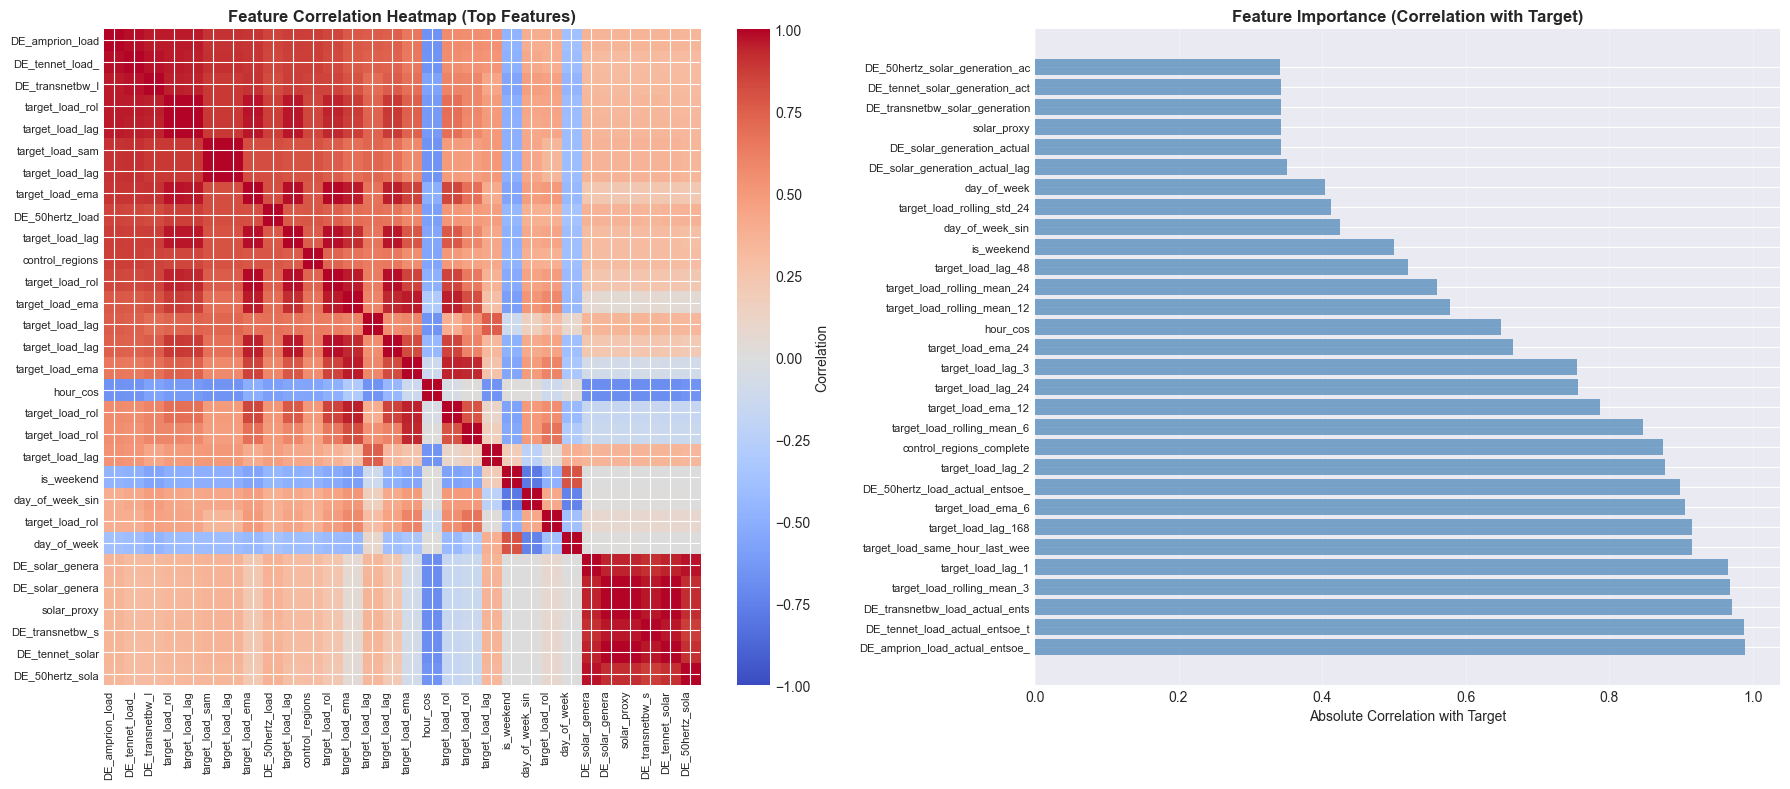

Step 13 visualizations saved!


In [25]:
# Visualizations for Step 13
# Limit features for visualization
viz_features = numeric_cols[:30] if len(numeric_cols) > 30 else numeric_cols

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. Correlation heatmap
corr_viz = df[viz_features].corr()
im = axes[0].imshow(corr_viz.values, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[0].set_xticks(range(len(viz_features)))
axes[0].set_yticks(range(len(viz_features)))
axes[0].set_xticklabels([f[:15] for f in viz_features], rotation=90, ha='right', fontsize=8)
axes[0].set_yticklabels([f[:15] for f in viz_features], fontsize=8)
axes[0].set_title('Feature Correlation Heatmap (Top Features)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=axes[0], label='Correlation')

# 2. Correlation with target
corr_with_target = df[viz_features].corrwith(df['target_load']).abs().sort_values(ascending=False)
axes[1].barh(range(len(corr_with_target)), corr_with_target.values, color='steelblue', alpha=0.7)
axes[1].set_yticks(range(len(corr_with_target)))
axes[1].set_yticklabels([f[:30] for f in corr_with_target.index], fontsize=8)
axes[1].set_xlabel('Absolute Correlation with Target', fontsize=10)
axes[1].set_title('Feature Importance (Correlation with Target)', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f'../saved_model_outputs/eda_outputs/step13_multicollinearity_{RESOLUTION}.png', dpi=300, bbox_inches='tight')
plt.show()

print("Step 13 visualizations saved!")


---
# Step 14: Summary and Decisions for Modeling

Time to summarize everything I found and make decisions about how to build the models.


- Key findings from the EDA
- What parameters to use for SARIMA
- What features to include in LSTM
- How to split train/test data
- What metrics to use for evaluation



In [26]:

print("="*80)
print("STEP 14: EDA SUMMARY & DESIGN DECISIONS")
print("="*80)

# Summary
eda_summary = {
    'resolution': RESOLUTION,
    'dataset_info': {
        'shape': df.shape,
        'time_range': f"{df.index.min()} to {df.index.max()}",
        'duration_days': (df.index.max() - df.index.min()).days
    },
    'target_statistics': {
        'mean': float(target.mean()),
        'std': float(target.std()),
        'min': float(target.min()),
        'max': float(target.max()),
        'skewness': float(scipy_stats.skew(target)),
        'kurtosis': float(scipy_stats.kurtosis(target))
    },
    'seasonality': {
        'daily_period': 24 if RESOLUTION == '60min' else 48 if RESOLUTION == '30min' else 96,
        'weekly_period': 168 if RESOLUTION == '60min' else 336 if RESOLUTION == '30min' else 672,
        'peak_hour': int(hourly_avg.idxmax()),
        'peak_day': day_names[daily_avg.idxmax()],
        'peak_month': month_names[monthly_avg.idxmax()-1]
    },
    'stationarity': {
        'adf_pvalue': float(adf_pvalue) if 'adf_pvalue' in locals() else None,
        'kpss_pvalue': float(kpss_pvalue) if 'kpss_pvalue' in locals() else None,
        'needs_differencing': adf_pvalue > 0.05 if 'adf_pvalue' in locals() else None
    },
    'peak_load': {
        'threshold_90th': float(peak_threshold),
        'peak_percentage': float(peak_percentage),
        'peak_count': int(peak_count)
    },
    'key_lags': key_lags if 'key_lags' in locals() else [],
    'weather_features': weather_cols if 'weather_cols' in locals() else [],
    'high_correlation_pairs': len(high_corr_pairs) if 'high_corr_pairs' in locals() else 0
}

print("\n" + "="*80)
print("KEY FINDINGS SUMMARY")
print("="*80)

print(f"\n1. Dataset: {eda_summary['resolution']} resolution")
print(f"   - Shape: {eda_summary['dataset_info']['shape']}")
print(f"   - Time range: {eda_summary['dataset_info']['time_range']}")

print(f"\n2. Target Variable:")
print(f"   - Mean: {eda_summary['target_statistics']['mean']:,.2f} MW")
print(f"   - Std: {eda_summary['target_statistics']['std']:,.2f} MW")
print(f"   - Range: {eda_summary['target_statistics']['min']:,.2f} to {eda_summary['target_statistics']['max']:,.2f} MW")

print(f"\n3. Seasonality:")
print(f"   - Daily period: {eda_summary['seasonality']['daily_period']}")
print(f"   - Weekly period: {eda_summary['seasonality']['weekly_period']}")
print(f"   - Peak hour: {eda_summary['seasonality']['peak_hour']}")
print(f"   - Peak day: {eda_summary['seasonality']['peak_day']}")

if eda_summary['stationarity']['needs_differencing'] is not None:
    print(f"\n4. Stationarity:")
    print(f"   - Needs differencing: {eda_summary['stationarity']['needs_differencing']}")

print(f"\n5. Peak Load:")
print(f"   - 90th percentile threshold: {eda_summary['peak_load']['threshold_90th']:,.2f} MW")
print(f"   - Peak periods: {eda_summary['peak_load']['peak_percentage']:.2f}% of data")

print("\n" + "="*80)


STEP 14: EDA SUMMARY & DESIGN DECISIONS

KEY FINDINGS SUMMARY

1. Dataset: 60min resolution
   - Shape: (32688, 83)
   - Time range: 2015-01-08 00:00:00+00:00 to 2018-09-30 23:00:00+00:00

2. Target Variable:
   - Mean: 55,697.94 MW
   - Std: 10,025.70 MW
   - Range: 31,307.00 to 77,549.00 MW

3. Seasonality:
   - Daily period: 24
   - Weekly period: 168
   - Peak hour: 10
   - Peak day: Wednesday

4. Stationarity:
   - Needs differencing: False

5. Peak Load:
   - 90th percentile threshold: 68,855.00 MW
   - Peak periods: 10.01% of data



In [27]:
# Design Decisions
design_decisions = {
    'sarima_parameters': {
        'seasonal_period': eda_summary['seasonality']['weekly_period'],  # Weekly seasonality
        'differencing_order': 1 if eda_summary['stationarity']['needs_differencing'] else 0,
        'seasonal_differencing': 1,
        'note': 'Parameters to be tuned via grid search, but these are starting points'
    },
    'lstm_features': {
        'window_length': eda_summary['seasonality']['weekly_period'],  # 1 week of history
        'key_lags': eda_summary['key_lags'],
        'calendar_features': ['hour', 'day_of_week', 'month', 'is_weekend', 'is_holiday'],
        'weather_features': eda_summary['weather_features'],
        'note': 'Include lagged features, calendar features, and weather proxies'
    },
    'peak_threshold': {
        'value': eda_summary['peak_load']['threshold_90th'],
        'method': '90th percentile',
        'note': 'Use for peak load analysis and evaluation'
    },
    'validation_strategy': {
        'method': 'Time-based split',
        'train_size': 0.7,
        'test_size': 0.15,
        'validation_size': 0.15,
        'note': 'Maintain temporal order, evaluate on recent data'
    },
    'evaluation_metrics': {
        'primary': ['MAE', 'RMSE', 'MAPE'],
        'peak_specific': ['Peak MAE', 'Peak RMSE'],
        'note': 'Evaluate overall performance and peak-specific performance'
    },
    'feature_selection': {
        'remove_highly_correlated': True,
        'correlation_threshold': 0.8,
        'note': 'Remove redundant features to improve model efficiency'
    }
}

print("="*80)
print("DESIGN DECISIONS FOR MODELING")
print("="*80)

print("\n1. SARIMA Parameters:")
for key, value in design_decisions['sarima_parameters'].items():
    if key != 'note':
        print(f"   - {key}: {value}")
print(f"   - Note: {design_decisions['sarima_parameters']['note']}")

print("\n2. LSTM Features:")
for key, value in design_decisions['lstm_features'].items():
    if key != 'note':
        if isinstance(value, list):
            print(f"   - {key}: {value[:5]}..." if len(value) > 5 else f"   - {key}: {value}")
        else:
            print(f"   - {key}: {value}")
print(f"   - Note: {design_decisions['lstm_features']['note']}")

print("\n3. Peak Threshold:")
print(f"   - Value: {design_decisions['peak_threshold']['value']:,.2f} MW")
print(f"   - Method: {design_decisions['peak_threshold']['method']}")

print("\n4. Validation Strategy:")
for key, value in design_decisions['validation_strategy'].items():
    if key != 'note':
        print(f"   - {key}: {value}")
print(f"   - Note: {design_decisions['validation_strategy']['note']}")

print("\n5. Evaluation Metrics:")
print(f"   - Primary: {design_decisions['evaluation_metrics']['primary']}")
print(f"   - Peak-specific: {design_decisions['evaluation_metrics']['peak_specific']}")

print("\n" + "="*80)

# Save summary to JSON
summary_path = f'../saved_model_outputs/eda_outputs/eda_summary_{RESOLUTION}.json'
with open(summary_path, 'w') as f:
    json.dump({
        'eda_summary': eda_summary,
        'design_decisions': design_decisions
    }, f, indent=2, default=str)

print(f"\nEDA summary saved to: {summary_path}")
print("="*80)


DESIGN DECISIONS FOR MODELING

1. SARIMA Parameters:
   - seasonal_period: 168
   - differencing_order: 0
   - seasonal_differencing: 1
   - Note: Parameters to be tuned via grid search, but these are starting points

2. LSTM Features:
   - window_length: 168
   - key_lags: [1, 6, 12, 24, 48]...
   - calendar_features: ['hour', 'day_of_week', 'month', 'is_weekend', 'is_holiday']
   - weather_features: ['solar_proxy', 'wind_proxy', 'temp_proxy', 'DE_solar_generation_actual', 'DE_wind_generation_actual']
   - Note: Include lagged features, calendar features, and weather proxies

3. Peak Threshold:
   - Value: 68,855.00 MW
   - Method: 90th percentile

4. Validation Strategy:
   - method: Time-based split
   - train_size: 0.7
   - test_size: 0.15
   - validation_size: 0.15
   - Note: Maintain temporal order, evaluate on recent data

5. Evaluation Metrics:
   - Primary: ['MAE', 'RMSE', 'MAPE']
   - Peak-specific: ['Peak MAE', 'Peak RMSE']


EDA summary saved to: ../saved_model_outputs/eda_

---
# Additional: Resolution Comparison & Feature Importance

## Purpose
Compare patterns across different resolutions and identify most important features.

## What We Analyze:
1. Statistical comparison across resolutions
2. Feature importance ranking
3. Recommendations for resolution selection


In [28]:
# Bonus: Feature importance and resolution comparison
print("="*80)
print("RESOLUTION COMPARISON & FEATURE IMPORTANCE")
print("="*80)

# Which features are most correlated with the target?
print("\n1. Top 20 Features by Correlation with Target:")
# Get numeric columns if not already defined
if 'numeric_cols' not in locals() or len(numeric_cols) == 0:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'target_load' in numeric_cols:
        numeric_cols.remove('target_load')

if len(numeric_cols) > 0:
    feature_importance = df[numeric_cols].corrwith(df['target_load']).abs().sort_values(ascending=False)
    top_features = feature_importance.head(20)
    
    print("\n   Rank | Feature | Correlation")
    print("   " + "-"*50)
    for idx, (feat, corr) in enumerate(top_features.items(), 1):
        print(f"   {idx:3d} | {feat[:40]:40s} | {corr:.4f}")
else:
    print("    No numeric columns found for feature importance analysis")

# Resolution comparison summary
print("\n2. Resolution Comparison Summary:")


print("\n3. Recommendations:")
print("   - 60min: Best for SARIMA (standard hourly data)")
print("   - 15min: Best for capturing short-term variations")
print("   - 30min: Balanced between granularity and computational cost")
print("   - Choose based on forecast horizon and computational resources")

print("\n" + "="*80)
print("EDA COMPLETE!")
print("="*80)
print("\nNext Steps:")
print("1. Review design decisions above")

print("="*80)


RESOLUTION COMPARISON & FEATURE IMPORTANCE

1. Top 20 Features by Correlation with Target:

   Rank | Feature | Correlation
   --------------------------------------------------
     1 | DE_amprion_load_actual_entsoe_transparen | 0.9884
     2 | DE_tennet_load_actual_entsoe_transparenc | 0.9881
     3 | DE_transnetbw_load_actual_entsoe_transpa | 0.9710
     4 | target_load_rolling_mean_3               | 0.9685
     5 | target_load_lag_1                        | 0.9658
     6 | target_load_same_hour_last_week          | 0.9158
     7 | target_load_lag_168                      | 0.9158
     8 | target_load_ema_6                        | 0.9062
     9 | DE_50hertz_load_actual_entsoe_transparen | 0.8991
    10 | target_load_lag_2                        | 0.8775
    11 | control_regions_complete                 | 0.8751
    12 | target_load_rolling_mean_6               | 0.8473
    13 | target_load_ema_12                       | 0.7872
    14 | target_load_lag_24                       | 0.7